# NB03 — Targeted Jacobian with Known Regulatory Pairs

**Question**: For KDs within the same pathway, is ∂E[Y_target] / ∂X_regulator elevated compared to cross-pathway controls?

This converts the noisy full-matrix Jacobian comparison (NB05) into a scalar hypothesis-driven pathway test. Instead of comparing 2000×2000 matrices, we ask: for specific (regulator_i, target_j) gene pairs, does the model's sensitivity change depending on which gene is knocked down?

**Pathway panels**:
- Secretory: regulators=[TRAPPC3, TRAPPC5, SRP54], targets=[SEC24A, ARFGEF2, MFGE8], KDs=[TRAPPC3, TRAPPC5, SRP54] vs neg_ctrl=[MYC, MAX, PAXBP1]
- Ribosome: regulators=[RPL5, RPS6, RPL11], targets=[RPL24, RPS15, RPL26], KDs=[RPL5, RPS6, RPL11] vs neg_ctrl=[MYC, MAX, PAXBP1]


## Setup: kernel and Python path

In [1]:
import subprocess, sys

# Ensure we use the correct conda env Python
conda_python = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
result = subprocess.run([conda_python, '--version'], capture_output=True, text=True)
print("Conda Python:", result.stdout.strip(), result.stderr.strip())

# Check if we're already in the right env
print("Current Python:", sys.executable)


Conda Python: Python 3.10.19 
Current Python: /mnt/polished-lake/home/mbeheleramass/.venv/bin/python


In [2]:
import subprocess, sys

# Get site-packages from conda env
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', 'import sys; print("\n".join(sys.path))'],
    capture_output=True, text=True
)
conda_paths = [p for p in result.stdout.strip().split('\n') if p]
print("Conda sys.path:")
for p in conda_paths:
    print(" ", p)


Conda sys.path:


In [3]:
import subprocess, sys

# Get site-packages from conda env
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', 'import sys; print(sys.path)'],
    capture_output=True, text=True
)
print("STDOUT:", result.stdout[:2000])
print("STDERR:", result.stderr[:500])


STDOUT: ['', '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python310.zip', '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10', '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/lib-dynload', '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages']

STDERR: 


In [4]:
import sys

# Insert conda env paths before current paths
conda_site = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages'
state_src = '/mnt/polished-lake/home/mbeheleramass/state/src'

for p in [conda_site, state_src]:
    if p not in sys.path:
        sys.path.insert(0, p)

print("Updated sys.path (first 8):", sys.path[:8])


Updated sys.path (first 8): ['/mnt/polished-lake/home/mbeheleramass/state/src', '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python313.zip', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13/lib-dynload', '', '/mnt/polished-lake/home/mbeheleramass/.venv/lib/python3.13/site-packages']


In [5]:
import importlib
import torch
print("torch version:", torch.__version__)
print("torch location:", torch.__file__)


ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python -m pip install --no-build-isolation -v . && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python -m pip install --no-build-isolation -v -e . && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [6]:
import os
print("CWD:", os.getcwd())
# Check if there's a torch directory in CWD
import glob
torch_dirs = glob.glob(os.path.join(os.getcwd(), 'torch*'))
print("torch dirs in CWD:", torch_dirs)


CWD: /mnt/polished-lake/home/mbeheleramass
torch dirs in CWD: []


In [7]:
import sys

# The '' (empty string = CWD) in sys.path is the problem when CWD has state/src issues
# Remove '' from sys.path and re-check
sys.path = [p for p in sys.path if p != '']

# Re-insert conda site-packages at the front, then state/src
conda_site = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages'
state_src = '/mnt/polished-lake/home/mbeheleramass/state/src'

# Remove any prior insertions
sys.path = [p for p in sys.path if p not in (conda_site, state_src)]

# Add in correct order: conda site-packages first so torch loads from there
sys.path.insert(0, state_src)
sys.path.insert(0, conda_site)

print("sys.path:", sys.path[:6])


sys.path: ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages', '/mnt/polished-lake/home/mbeheleramass/state/src', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python313.zip', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13/lib-dynload', '/mnt/polished-lake/home/mbeheleramass/.venv/lib/python3.13/site-packages']


In [8]:
import importlib
# Force reimport of torch from the correct location
if 'torch' in sys.modules:
    del sys.modules['torch']
    # Also clear submodules
    to_del = [k for k in sys.modules if k.startswith('torch')]
    for k in to_del:
        del sys.modules[k]

import torch
print("torch version:", torch.__version__)
print("torch location:", torch.__file__)
print("CUDA available:", torch.cuda.is_available())


ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python -m pip install --no-build-isolation -v . && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python -m pip install --no-build-isolation -v -e . && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [9]:
import subprocess, os

# Test that the conda python can import torch
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', 'import torch; print(torch.__version__); print("CUDA:", torch.cuda.is_available())'],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:500] if result.stderr else "")
print("returncode:", result.returncode)


STDOUT: 2.10.0+cu128
CUDA: True

STDERR: 
returncode: 0


In [10]:
import subprocess, os

# Verify the full model loading pipeline works from conda env (from /tmp)
test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import torch, pickle
print("torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())

var_dims = pickle.load(open(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl', 'rb'
))
gene_names = var_dims['gene_names']
print("gene_names length:", len(gene_names))
print("First 5 genes:", gene_names[:5])
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:1000] if result.stderr else "")
print("returncode:", result.returncode)


STDOUT: torch: 2.10.0+cu128
CUDA: True
gene_names length: 2000
First 5 genes: ['HES4', 'ISG15', 'MIB2', 'CEP104', 'ACOT7']

STDERR: 
returncode: 0


In [11]:
import subprocess

# Check pert_onehot_map keys and adata obs columns
test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import torch, anndata as ad, numpy as np

# Load pert map
pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location='cpu'
)
print("pert_map type:", type(pert_map))
print("pert_map keys (first 20):", list(pert_map.keys())[:20])

# Check pathway genes in pert_map
pathway_genes = ['TRAPPC3', 'TRAPPC5', 'SRP54', 'MYC', 'MAX', 'PAXBP1',
                 'RPL5', 'RPS6', 'RPL11']
for g in pathway_genes:
    print(f"  {g}: {'FOUND' if g in pert_map else 'MISSING'}")
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:1000] if result.stderr else "")


STDOUT: 
STDERR: Traceback (most recent call last):
  File "<string>", line 7, in <module>
  File "/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages/torch/serialization.py", line 1548, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allow

In [12]:
import subprocess

# Check pert_onehot_map keys and adata obs columns
test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import torch, anndata as ad, numpy as np

# Load pert map (weights_only=False needed for non-tensor data)
pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location='cpu', weights_only=False
)
print("pert_map type:", type(pert_map))
keys = list(pert_map.keys())
print("Total KDs:", len(keys))
print("pert_map keys (first 20):", keys[:20])

# Check pathway genes in pert_map
pathway_genes = ['TRAPPC3', 'TRAPPC5', 'SRP54', 'MYC', 'MAX', 'PAXBP1',
                 'RPL5', 'RPS6', 'RPL11']
for g in pathway_genes:
    print(f"  {g}: {'FOUND' if g in pert_map else 'MISSING'}")
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:1000] if result.stderr else "")


STDOUT: pert_map type: <class 'dict'>
Total KDs: 2024
pert_map keys (first 20): [np.str_('AAAS'), np.str_('AAMP'), np.str_('AAR2'), np.str_('AARS'), np.str_('AARS2'), np.str_('AASDHPPT'), np.str_('AATF'), np.str_('ABCB10'), np.str_('ABCB7'), np.str_('ABCE1'), np.str_('ABHD11'), np.str_('ABHD17A'), np.str_('ABT1'), np.str_('AC118549.1'), np.str_('ACD'), np.str_('ACSS2'), np.str_('ACTB'), np.str_('ACTL6A'), np.str_('ACTR10'), np.str_('ACTR1B')]
  TRAPPC3: FOUND
  TRAPPC5: FOUND
  SRP54: FOUND
  MYC: FOUND
  MAX: FOUND
  PAXBP1: FOUND
  RPL5: FOUND
  RPS6: FOUND
  RPL11: FOUND

STDERR: 


In [13]:
import subprocess

test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import anndata as ad, numpy as np

adata = ad.read_h5ad(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/'
    'Replogle-Nadig-Preprint/replogle_matched_hvg.h5ad'
)
print("adata.obs.columns:", list(adata.obs.columns))
print("adata.obsm.keys():", list(adata.obsm.keys()))
print("adata.shape:", adata.shape)

# Check cell_line values
if 'cell_line' in adata.obs.columns:
    print("cell_line values:", adata.obs['cell_line'].unique().tolist())

# Check gene/pert column
for col in ['gene', 'pert_name', 'perturbation']:
    if col in adata.obs.columns:
        print(f"{col} unique (first 5):", adata.obs[col].unique()[:5].tolist())
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:1000] if result.stderr else "")


STDOUT: adata.obs.columns: ['gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'cell_line', 'S_score', 'G2M_score', 'phase']
adata.obsm.keys(): ['X_hvg']
adata.shape: (643413, 6642)
cell_line values: ['hepg2', 'jurkat', 'k562', 'rpe1']
gene unique (first 5): ['KIAA1143', 'SEPHS2', 'POLR2H', 'TFAM', 'TMEM214']

STDERR: 


In [14]:
import subprocess

test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import anndata as ad, numpy as np

adata = ad.read_h5ad(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/'
    'Replogle-Nadig-Preprint/replogle_matched_hvg.h5ad'
)

# Check non-targeting control labels used
hepg2_ctrl_labels = adata.obs[adata.obs['cell_line'] == 'hepg2']['gene'].value_counts()
print("Top 10 gene labels in hepg2:")
print(hepg2_ctrl_labels.head(10))

# X_hvg shape check
ctrl_mask = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'].isin(['non-targeting', 'NT']))
print("HepG2 NT cells:", ctrl_mask.sum())

# Also check 'non-targeting' variations
nt_variants = adata.obs[adata.obs['cell_line'] == 'hepg2']['gene'].str.lower().unique()
nt_variants = [g for g in nt_variants if 'non' in g or 'nt' == g.lower() or 'ctrl' in g.lower()]
print("NT variant labels:", nt_variants[:10])

# X_hvg shape
print("X_hvg shape:", adata.obsm['X_hvg'].shape)
print("X_hvg dtype:", adata.obsm['X_hvg'].dtype)
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:500] if result.stderr else "")


STDOUT: Top 10 gene labels in hepg2:
gene
non-targeting    4976
TFAM             1166
GFM1              717
SLC1A5            455
GTF2E2            450
SMN2              446
PPP6C             433
ZDHHC7            424
MRPL36            415
CCDC6             396
Name: count, dtype: int64
HepG2 NT cells: 4976
NT variant labels: ['non-targeting']
X_hvg shape: (643413, 2000)
X_hvg dtype: float32

STDERR: 


In [15]:
import subprocess

test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import torch

# Load model
from state.tx.models.state_transition import StateTransitionPerturbationModel

ckpt_path = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StateTransitionPerturbationModel.load_from_checkpoint(
    ckpt_path, map_location=device
)
model.eval()
print("Model loaded. Device:", device)

# Check predict_step signature
import inspect
sig = inspect.signature(model.predict_step)
print("predict_step signature:", sig)

# Check forward signature too
sig_fwd = inspect.signature(model.forward)
print("forward signature:", sig_fwd)
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:2000] if result.stderr else "")


STDOUT: StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (gene_decoder): LatentToGeneDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=2000, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): GELU(approximate='none')
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=2000, bias=True)
      (13): ReLU()
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in_features=2024, out_features=328, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear

In [16]:
import subprocess

test_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import torch, pickle, anndata as ad, numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
from state.tx.models.state_transition import StateTransitionPerturbationModel
ckpt_path = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'
model = StateTransitionPerturbationModel.load_from_checkpoint(ckpt_path, map_location=device)
model.eval()

# Load gene names
var_dims = pickle.load(open(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl', 'rb'
))
gene_names = var_dims['gene_names']

# Load pert map
pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location=device, weights_only=False
)

# Load control cells
adata = ad.read_h5ad(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/'
    'Replogle-Nadig-Preprint/replogle_matched_hvg.h5ad'
)
ctrl_mask = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'] == 'non-targeting')
ctrl_mat = adata.obsm['X_hvg'][ctrl_mask]
print(f"ctrl cells: {ctrl_mat.shape}")

np.random.seed(42)
idx = np.random.choice(len(ctrl_mat), size=16, replace=False)  # use 16 for speed test
ctrl_cells = torch.tensor(ctrl_mat[idx], dtype=torch.float32)

# Test predict_step output structure
kd = 'TRAPPC3'
pert_vec = pert_map[kd].to(device)
print(f"pert_vec shape: {pert_vec.shape}")

ctrl_in = ctrl_cells.clone().to(device).requires_grad_(True)
pert_expanded = pert_vec.unsqueeze(0).expand(len(ctrl_cells), -1)
batch = {'ctrl_cell_emb': ctrl_in, 'pert_emb': pert_expanded}
with torch.no_grad():
    out = model.predict_step(batch, batch_idx=0, padded=False)
print("predict_step output keys:", list(out.keys()))
print("preds shape:", out['preds'].shape)
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', test_code],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:2000] if result.stderr else "")


STDOUT: StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (gene_decoder): LatentToGeneDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=2000, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): GELU(approximate='none')
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=2000, bias=True)
      (13): ReLU()
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in_features=2024, out_features=328, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear

## Section 1: Setup and Data Loading

The kernel runs Python 3.13, but the model requires Python 3.10 (conda env). All heavy computation is run via subprocess calls to the conda Python, saving results as numpy/parquet files which are loaded back for visualization.

In [17]:
import subprocess, os, sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import wilcoxon, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Output directory
OUT_DIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
os.makedirs(OUT_DIR, exist_ok=True)

CONDA_PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'

def run_conda(code, label=''):
    """Run code snippet in the conda Python environment."""
    result = subprocess.run(
        [CONDA_PYTHON, '-c', code],
        capture_output=True, text=True, cwd='/tmp'
    )
    if result.returncode != 0:
        print(f"[{label}] STDERR:\n{result.stderr[:2000]}")
    else:
        print(f"[{label}] OK")
    return result

print("Setup complete. OUT_DIR:", OUT_DIR)


ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

In [18]:
import sys

# Remove conda 3.10 site-packages from sys.path to restore clean Python 3.13 env
conda_site = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages'
state_src = '/mnt/polished-lake/home/mbeheleramass/state/src'

sys.path = [p for p in sys.path if p not in (conda_site, state_src)]

# Re-add '' (CWD) if needed for standard behavior
if '' not in sys.path:
    sys.path.insert(0, '')

# Clear any broken module caches
for key in list(sys.modules.keys()):
    if key in ('numpy', 'pandas', 'matplotlib') or key.startswith(('numpy.', 'pandas.', 'matplotlib.')):
        del sys.modules[key]

print("Cleaned sys.path:", sys.path[:6])


Cleaned sys.path: ['', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python313.zip', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13/lib-dynload', '/mnt/polished-lake/home/mbeheleramass/.venv/lib/python3.13/site-packages']


In [19]:
import subprocess, os, sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Output directory
OUT_DIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
os.makedirs(OUT_DIR, exist_ok=True)

CONDA_PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'

def run_conda(code, label=''):
    """Run code snippet in the conda Python environment from /tmp to avoid CWD conflicts."""
    result = subprocess.run(
        [CONDA_PYTHON, '-c', code],
        capture_output=True, text=True, cwd='/tmp'
    )
    if result.returncode != 0:
        print(f"[{label}] STDERR:\n{result.stderr[:3000]}")
    else:
        if result.stdout:
            print(f"[{label}] STDOUT: {result.stdout[:500]}")
        print(f"[{label}] SUCCESS")
    return result

print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("Setup complete. OUT_DIR:", OUT_DIR)


ModuleNotFoundError: No module named 'numpy'

In [20]:
import sys
print("Python:", sys.version)
print("Executable:", sys.executable)
print("sys.path:", sys.path)


Python: 3.13.12 (main, Feb 12 2026, 00:45:41) [Clang 21.1.4 ]
Executable: /mnt/polished-lake/home/mbeheleramass/.venv/bin/python
sys.path: ['', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python313.zip', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13', '/mnt/polished-lake/home/mbeheleramass/.local/share/uv/python/cpython-3.13.12-linux-x86_64-gnu/lib/python3.13/lib-dynload', '/mnt/polished-lake/home/mbeheleramass/.venv/lib/python3.13/site-packages']


In [21]:
import subprocess
# Check what packages are in the venv
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.venv/bin/python', '-c',
     'import numpy; print(numpy.__version__); import pandas; print(pandas.__version__); import matplotlib; print(matplotlib.__version__)'],
    capture_output=True, text=True, cwd='/tmp'
)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr[:500])


STDOUT: 
STDERR: Traceback (most recent call last):
  File "<string>", line 1, in <module>
    import numpy; print(numpy.__version__); import pandas; print(pandas.__version__); import matplotlib; print(matplotlib.__version__)
    ^^^^^^^^^^^^
ModuleNotFoundError: No module named 'numpy'



In [22]:
import subprocess
# What's in the venv site-packages?
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.venv/bin/python', '-c',
     'import pkgutil; pkgs = [m.name for m in pkgutil.iter_modules()]; print(sorted(pkgs)[:50])'],
    capture_output=True, text=True, cwd='/tmp'
)
print("venv packages:", result.stdout[:1000])

# Check pyproject.toml for dependencies
result2 = subprocess.run(['cat', '/mnt/polished-lake/home/mbeheleramass/pyproject.toml'],
                         capture_output=True, text=True)
print("pyproject.toml:\n", result2.stdout[:1000])


venv packages: ['IPython', 'PIL', '__future__', '__hello__', '__phello__', '_aix_support', '_android_support', '_apple_support', '_argon2_cffi_bindings', '_cffi_backend', '_collections_abc', '_colorize', '_compat_pickle', '_compression', '_ctypes_test', '_dbm', '_ios_support', '_markupbase', '_opcode_metadata', '_osx_support', '_py_abc', '_pydatetime', '_pydecimal', '_pyio', '_pylong', '_pyrepl', '_sitebuiltins', '_strptime', '_sysconfigdata__linux_x86_64-linux-gnu', '_threading_local', '_tkinter', '_virtualenv', '_weakrefset', '_yaml', 'abc', 'add_narratives', 'agent_0_bu1gwlc0', 'agent_0_jqsn8ypc', 'agent_0_nj9himaw', 'agent_1_4tw8j0g0', 'agent_1_e0fnlyi_', 'agent_2_tg6j9n9l', 'agent_2_uh9bntzj', 'agent_2_uqcc8l3q', 'aiofile', 'analyze_058', 'analyze_059', 'analyze_060', 'annotated_types', 'antigravity']

pyproject.toml:
 [project]
name = "mbeheleramass"
version = "0.1.0"
description = "Add your description here"
readme = "README.md"
requires-python = ">=3.13"
dependencies = [
    "s

In [23]:
import subprocess

# Write the full analysis script to a file
SCRIPT_PATH = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py'

SCRIPT = '''#!/usr/bin/env python
"""
NB03 Targeted Jacobian Analysis — Compute Jacobians
Runs in the conda env (Python 3.10 + pytorch/state).
Saves results to jacobian_analysis/nb03_*.npy and nb03_results.parquet
"""
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')

import torch
import pickle
import numpy as np
import pandas as pd
import anndata as ad
import time

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_BASE = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle'
CKPT_PATH  = f'{MODEL_BASE}/fewshot/hepg2/checkpoints/best.ckpt'
VAR_DIMS   = f'{MODEL_BASE}/fewshot/hepg2/var_dims.pkl'
PERT_MAP   = f'{MODEL_BASE}/fewshot/hepg2/pert_onehot_map.pt'
DATA_PATH  = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/'
              'Replogle-Nadig-Preprint/replogle_matched_hvg.h5ad')
OUT_DIR    = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# ─── Device ───────────────────────────────────────────────────────────────────
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# ─── Load model ───────────────────────────────────────────────────────────────
from state.tx.models.state_transition import StateTransitionPerturbationModel
model = StateTransitionPerturbationModel.load_from_checkpoint(CKPT_PATH, map_location=device)
model.eval()
print("Model loaded.")

# ─── Load auxiliary data ──────────────────────────────────────────────────────
var_dims   = pickle.load(open(VAR_DIMS, 'rb'))
gene_names = var_dims['gene_names']   # list of 2000 gene names
gene2idx   = {g: i for i, g in enumerate(gene_names)}

pert_map   = torch.load(PERT_MAP, map_location=device, weights_only=False)
print(f"Gene index size: {len(gene_names)}, KDs available: {len(pert_map)}")

# ─── Load control cells ───────────────────────────────────────────────────────
adata      = ad.read_h5ad(DATA_PATH)
ctrl_mask  = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'] == 'non-targeting')
ctrl_mat   = adata.obsm['X_hvg'][ctrl_mask]   # [N, 2000]
print(f"Control cells: {ctrl_mat.shape}")

np.random.seed(42)
n_cells    = 64  # model cell_set_len
idx        = np.random.choice(len(ctrl_mat), size=n_cells, replace=False)
ctrl_cells = torch.tensor(ctrl_mat[idx], dtype=torch.float32).to(device)

# ─── Targeted Jacobian function ───────────────────────────────────────────────
def targeted_jacobian(model, ctrl_cells, pert_key, input_gene_idx, output_gene_idx):
    """
    Compute scalar dY[output] / dX[input] under given KD.
    Uses mean-cell expansion so the gradient is clean (see spec note on cell-set Jacobian).
    Returns: scalar float
    """
    S = len(ctrl_cells)
    # Use mean control cell as representative; vary input_gene as differential
    X_mean = ctrl_cells.mean(0).detach().clone()   # [2000]
    X_mean.requires_grad_(True)

    # Expand to S cells (same cell, so off-diagonal cross-cell gradients cancel)
    X_expanded = X_mean.unsqueeze(0).expand(S, -1)  # [S, 2000]

    pert_vec  = pert_map[pert_key].float()
    pert_exp  = pert_vec.unsqueeze(0).expand(S, -1).to(device)
    batch_t   = torch.zeros(S, dtype=torch.long, device=device)

    batch_dict = {
        'ctrl_cell_emb': X_expanded,
        'pert_emb':      pert_exp,
        'pert_name':     [pert_key] * S,
        'batch':         batch_t,
    }
    out = model.predict_step(batch_dict, batch_idx=0, padded=False)
    preds   = out['preds'].reshape(-1, out['preds'].shape[-1])  # [S, 2000]
    target  = preds[:, output_gene_idx].mean()
    target.backward()

    J = X_mean.grad[input_gene_idx].item()
    return J


# ─── Pathway panels ───────────────────────────────────────────────────────────
# Secretory pathway
sec_regulators   = ['TRAPPC3', 'TRAPPC5', 'SRP54']
sec_targets      = ['SEC24A', 'ARFGEF2', 'MFGE8']
sec_kds          = ['TRAPPC3', 'TRAPPC5', 'SRP54']
neg_ctrl_kds     = ['MYC', 'MAX', 'PAXBP1']

# Ribosome pathway
ribo_regulators  = ['RPL5', 'RPS6', 'RPL11']
ribo_targets     = ['RPL24', 'RPS15', 'RPL26']
ribo_kds         = ['RPL5', 'RPS6', 'RPL11']

# Helper to check gene presence
def check_genes(names, kind):
    missing = []
    for g in names:
        if g not in gene2idx:
            print(f"  WARNING: {g} not in gene_names index, will skip")
            missing.append(g)
        if g not in pert_map and kind == 'kd':
            print(f"  WARNING: {g} not in pert_map, will skip")
            missing.append(g)
    return [g for g in names if g not in missing]

print("\\nChecking secretory genes...")
sec_regulators  = check_genes(sec_regulators, 'gene')
sec_targets     = check_genes(sec_targets, 'gene')
sec_kds         = check_genes(sec_kds, 'kd')
neg_ctrl_kds    = check_genes(neg_ctrl_kds, 'kd')

print("\\nChecking ribosome genes...")
ribo_regulators = check_genes(ribo_regulators, 'gene')
ribo_targets    = check_genes(ribo_targets, 'gene')
ribo_kds        = check_genes(ribo_kds, 'kd')

print("\\nAll gene panels verified.")


# ─── Compute Jacobians for both pathway panels ────────────────────────────────
results = []

def compute_panel(regulators, targets, pathway_kds, neg_kds, pathway_name):
    all_kds = pathway_kds + neg_kds
    for reg in regulators:
        if reg not in gene2idx:
            continue
        reg_idx = gene2idx[reg]
        for tgt in targets:
            if tgt not in gene2idx:
                continue
            tgt_idx = gene2idx[tgt]
            for kd in all_kds:
                if kd not in pert_map:
                    continue
                t0 = time.time()
                J = targeted_jacobian(model, ctrl_cells, kd, reg_idx, tgt_idx)
                elapsed = time.time() - t0
                results.append({
                    'pathway':     pathway_name,
                    'regulator':   reg,
                    'target':      tgt,
                    'kd':          kd,
                    'pathway_kd':  kd in pathway_kds,
                    'J':           J,
                    'elapsed_s':   elapsed,
                })
                print(f"  [{pathway_name}] {reg}->{tgt} | KD={kd} | J={J:.6f} | {elapsed:.1f}s")

print("\\n=== Computing SECRETORY panel ===")
compute_panel(sec_regulators, sec_targets, sec_kds, neg_ctrl_kds, 'secretory')

print("\\n=== Computing RIBOSOME panel ===")
compute_panel(ribo_regulators, ribo_targets, ribo_kds, neg_ctrl_kds, 'ribosome')

# ─── Save results ─────────────────────────────────────────────────────────────
df = pd.DataFrame(results)
df.to_parquet(f'{OUT_DIR}/nb03_jacobian_results.parquet', index=False)
print(f"\\nSaved {len(df)} rows to nb03_jacobian_results.parquet")
print(df.to_string())


# ─── Distribution analysis: all KDs for one illustrative pair ─────────────────
print("\\n=== Computing J distribution across ALL KDs for TRAPPC3 -> SEC24A ===")

# Use the sorted keys to iterate all KDs
all_kd_keys = sorted(pert_map.keys())
if 'TRAPPC3' in gene2idx and 'SEC24A' in gene2idx:
    reg_idx  = gene2idx['TRAPPC3']
    tgt_idx  = gene2idx['SEC24A']

    dist_results = []
    for i, kd in enumerate(all_kd_keys):
        J = targeted_jacobian(model, ctrl_cells, kd, reg_idx, tgt_idx)
        dist_results.append({'kd': str(kd), 'J': J})
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(all_kd_keys)} | last J={J:.6f}")

    df_dist = pd.DataFrame(dist_results)
    df_dist.to_parquet(f'{OUT_DIR}/nb03_distribution_trappc3_sec24a.parquet', index=False)
    print(f"Saved {len(df_dist)} KD Jacobians for TRAPPC3->SEC24A")

    # Quick stats
    sec_J = [r['J'] for r in dist_results if str(r['kd']) in sec_kds]
    neg_J = [r['J'] for r in dist_results if str(r['kd']) in neg_ctrl_kds]
    print(f"Secretory KDs mean J: {np.mean(sec_J):.6f}")
    print(f"Neg ctrl KDs mean J:  {np.mean(neg_J):.6f}")
else:
    print("TRAPPC3 or SEC24A not in gene index, skipping distribution analysis")

print("\\nDONE.")
'''

with open(SCRIPT_PATH, 'w') as f:
    f.write(SCRIPT)

print("Script written to:", SCRIPT_PATH)


Script written to: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py


## Section 2: Run Jacobian Computation (subprocess to conda Python)

The targeted Jacobian `dY[target] / dX[regulator]` is computed for each (regulator, target, KD) triple in both pathway panels (secretory and ribosome), plus across all 2024 KDs for the illustrative TRAPPC3->SEC24A pair.

In [24]:
import subprocess, time

SCRIPT_PATH = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py'
CONDA_PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
LOG_PATH = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.log'

print("Starting Jacobian computation (this will take ~20-40 minutes for all KDs)...")
print("Running script:", SCRIPT_PATH)
print("Log:", LOG_PATH)

t0 = time.time()
result = subprocess.run(
    [CONDA_PYTHON, SCRIPT_PATH],
    capture_output=True, text=True, cwd='/tmp', timeout=3600
)
elapsed = time.time() - t0
print(f"\nCompleted in {elapsed/60:.1f} minutes")
print(f"Return code: {result.returncode}")

# Save log
with open(LOG_PATH, 'w') as f:
    f.write(result.stdout)
    if result.stderr:
        f.write("\n\n=== STDERR ===\n")
        f.write(result.stderr)

if result.returncode == 0:
    print("SUCCESS")
    print("Last 3000 chars of stdout:")
    print(result.stdout[-3000:])
else:
    print("FAILED — stderr:")
    print(result.stderr[-3000:])
    print("stdout tail:")
    print(result.stdout[-2000:])


Starting Jacobian computation (this will take ~20-40 minutes for all KDs)...
Running script: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py
Log: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.log



Completed in 0.9 minutes
Return code: 0
SUCCESS
Last 3000 chars of stdout:
approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): GELU(approximate='none')
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=2000, bias=True)
      (13): ReLU()
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in_features=2024, out_features=328, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear(in_features=2000, out_features=328, bias=True)
  )
  (transformer_backbone): LlamaBidirectionalModel(
    (embed_tokens): Embedding(32000, 328, padding_idx=0)
    (layers): ModuleList(
      (0-7): 8 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=328, out_features=768, bias=False)
          (k_proj): Linear(in_features=328, out_features=768, bias=False)
         

In [25]:
import subprocess

check_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import pickle, torch

var_dims   = pickle.load(open(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl', 'rb'
))
gene_names = var_dims['gene_names']
gene_set   = set(gene_names)

# All genes we'd like to test
candidates = [
    # Secretory regulator/target candidates
    'TRAPPC3', 'TRAPPC5', 'TRAPPC2', 'TRAPPC4', 'TRAPPC8', 'TRAPPC9', 'TRAPPC10',
    'SRP54', 'SRP68', 'SRP72', 'SRP14', 'SRP9',
    'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D',
    'ARFGEF2', 'ARFGEF1', 'SEC13', 'SEC16A', 'SEC16B',
    'MFGE8', 'ATF6', 'XBP1', 'HSPA5', 'DDIT3',
    'SEC61A1', 'SEC61B', 'SEC63', 'SRP19',
    'COPB1', 'COPB2', 'COPA', 'COPG1', 'ARCN1',
    
    # Ribosome candidates
    'RPL5', 'RPL11', 'RPL24', 'RPL26', 'RPS6', 'RPS15',
    'RPL3', 'RPL4', 'RPL6', 'RPL7', 'RPL8', 'RPL10', 'RPL12', 'RPL13',
    'RPS2', 'RPS3', 'RPS4X', 'RPS5', 'RPS7', 'RPS8', 'RPS9',
    'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL19', 'RPL21', 'RPL22', 'RPL23',
    'RPL27', 'RPL28', 'RPL29', 'RPL30', 'RPL32', 'RPL34', 'RPL35', 'RPL36',
    'RPS10', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS16', 'RPS17', 'RPS18',
    'RPS19', 'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS27',
    
    # Negative controls
    'MYC', 'MAX', 'PAXBP1', 'TP53', 'STAT3', 'EGFR',
]

found = [(g, gene_names.index(g)) for g in candidates if g in gene_set]
missing = [g for g in candidates if g not in gene_set]

print("FOUND in HVG index:")
for g, i in found:
    print(f"  {g}: idx={i}")
print(f"\\nTotal found: {len(found)}")
print(f"\\nMISSING: {missing}")

# Also check pert_map
pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location='cpu', weights_only=False
)
pert_keys = set(str(k) for k in pert_map.keys())
print("\\nIn pert_map:")
for g, i in found:
    in_pm = g in pert_keys
    print(f"  {g}: {'FOUND' if in_pm else 'MISSING'}")
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', check_code],
    capture_output=True, text=True, cwd='/tmp', timeout=120
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[:1000])


FOUND in HVG index:
  SEC24A: idx=589
  ARFGEF2: idx=1846
  MFGE8: idx=1496
  XBP1: idx=1903
  HSPA5: idx=944
  DDIT3: idx=1244
  RPS6: idx=893
  RPL3: idx=1915
  RPL10: idx=1983
  RPL12: idx=946
  RPL13: idx=1573
  RPS8: idx=67
  RPL14: idx=370
  RPL17: idx=1715
  RPL29: idx=388
  RPL32: idx=348
  RPL34: idx=509
  RPS10: idx=668
  RPS18: idx=663
  RPS24: idx=1011
  RPS27: idx=131
  MYC: idx=880

Total found: 22

MISSING: ['TRAPPC3', 'TRAPPC5', 'TRAPPC2', 'TRAPPC4', 'TRAPPC8', 'TRAPPC9', 'TRAPPC10', 'SRP54', 'SRP68', 'SRP72', 'SRP14', 'SRP9', 'SEC24B', 'SEC24C', 'SEC24D', 'ARFGEF1', 'SEC13', 'SEC16A', 'SEC16B', 'ATF6', 'SEC61A1', 'SEC61B', 'SEC63', 'SRP19', 'COPB1', 'COPB2', 'COPA', 'COPG1', 'ARCN1', 'RPL5', 'RPL11', 'RPL24', 'RPL26', 'RPS15', 'RPL4', 'RPL6', 'RPL7', 'RPL8', 'RPS2', 'RPS3', 'RPS4X', 'RPS5', 'RPS7', 'RPS9', 'RPL15', 'RPL18', 'RPL19', 'RPL21', 'RPL22', 'RPL23', 'RPL27', 'RPL28', 'RPL30', 'RPL35', 'RPL36', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS16', 'RPS17', 'RPS19', 'RP

In [26]:
import subprocess

check_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import pickle, torch, numpy as np

var_dims   = pickle.load(open(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl', 'rb'
))
gene_names = var_dims['gene_names']
gene_set   = set(gene_names)

pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location='cpu', weights_only=False
)
pert_keys = [str(k) for k in pert_map.keys()]

# What ribosomal-related KDs exist in the pert_map?
ribo_kds = [k for k in pert_keys if k.startswith('RPL') or k.startswith('RPS')]
print("Ribosomal KDs in pert_map:", sorted(ribo_kds)[:30])
print(f"  Total ribo KDs: {len(ribo_kds)}")

# Of these, which ones are also in gene_names?
ribo_in_both = [k for k in ribo_kds if k in gene_set]
print(f"\\nRibo KDs also in gene_names: {sorted(ribo_in_both)}")

# Negative controls: what's available?
neg_candidates = ['MYC', 'MAX', 'PAXBP1', 'TP53', 'STAT3', 'EGFR', 'CDK4', 'CDK6',
                  'CCND1', 'MDM2', 'BRCA1', 'BRCA2', 'ATM', 'CHEK1', 'CHEK2']
neg_in_both = [(g, gene_names.index(g)) for g in neg_candidates if g in gene_set and g in pert_keys]
print(f"\\nNeg ctrl in both gene_names AND pert_map:")
for g, i in neg_in_both:
    print(f"  {g}: idx={i}")

# Secretory-pathway KDs
sec_candidates = ['TRAPPC3', 'TRAPPC5', 'SRP54', 'SAR1A', 'SAR1B',
                  'COPB1', 'COPB2', 'COPA', 'ARCN1', 'SEC61A1',
                  'HSPA5', 'ATF6', 'EIF2AK3', 'ERN1', 'ATF4',
                  'SEC16A', 'SEC16B', 'SEC13', 'SEC23A', 'SEC23B',
                  'SEC31A', 'GOSR2', 'GOSR1', 'STX5', 'BET1']
sec_in_pert = [g for g in sec_candidates if g in pert_keys]
sec_in_gene = [g for g in sec_candidates if g in gene_set]
sec_in_both = [g for g in sec_candidates if g in gene_set and g in pert_keys]
print(f"\\nSecretory pathway in pert_map: {sec_in_pert}")
print(f"Secretory pathway in gene_names: {sec_in_gene}")
print(f"Secretory pathway in BOTH: {sec_in_both}")

# What about TRAPPC3 specifically - is it in pert_map even if not in gene_names?
for g in ['TRAPPC3', 'TRAPPC5', 'SRP54']:
    print(f"  {g} in pert_map: {g in pert_keys}, in gene_names: {g in gene_set}")
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', check_code],
    capture_output=True, text=True, cwd='/tmp', timeout=120
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[:1000])


Ribosomal KDs in pert_map: ['RPL10', 'RPL10A', 'RPL11', 'RPL12', 'RPL13', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A', 'RPL19', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36', 'RPL36A', 'RPL36AL', 'RPL37']
  Total ribo KDs: 74

Ribo KDs also in gene_names: ['RPL10', 'RPL12', 'RPL13', 'RPL14', 'RPL17', 'RPL29', 'RPL32', 'RPL34', 'RPL36A', 'RPL37', 'RPL37A', 'RPL39', 'RPS10', 'RPS18', 'RPS24', 'RPS27', 'RPS6', 'RPS8']

Neg ctrl in both gene_names AND pert_map:
  MYC: idx=880
  BRCA1: idx=1636
  BRCA2: idx=1319
  CHEK1: idx=1174

Secretory pathway in pert_map: ['TRAPPC3', 'TRAPPC5', 'SRP54', 'HSPA5', 'ATF4', 'SEC16A', 'SEC13', 'GOSR2', 'STX5', 'BET1']
Secretory pathway in gene_names: ['HSPA5', 'ATF4', 'SEC23A']
Secretory pathway in BOTH: ['HSPA5', 'ATF4']
  TRAPPC3 in pert_map: True, in gene_names: False
  TRAPPC5 in pert_map: True, in gene_names: False
  SRP54 in pert_map: True, in gene_

In [27]:
import subprocess

# Get more complete view of what's available
check_code = """
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
import pickle, torch, numpy as np

var_dims   = pickle.load(open(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/var_dims.pkl', 'rb'
))
gene_names = var_dims['gene_names']
gene_set   = set(gene_names)

pert_map = torch.load(
    '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/'
    'ST-HVG-Replogle/fewshot/hepg2/pert_onehot_map.pt',
    map_location='cpu', weights_only=False
)
pert_keys = set(str(k) for k in pert_map.keys())

# Ribosome genes in BOTH
ribo_both = sorted([g for g in gene_set if (g.startswith('RPL') or g.startswith('RPS')) and g in pert_keys])
print("Ribo in BOTH gene_names AND pert_map:", ribo_both)

# Secretory pathway - genes in both
sec_both = sorted([g for g in gene_set if g in pert_keys and 
                   any(s in g for s in ['SEC', 'SRP', 'TRAP', 'ARF', 'COP', 'MFG', 'ATF', 'XBP', 'HSP', 'BET', 'GOL', 'STX', 'SAR', 'GOS'])])
print(f"\\nSecretory-ish in BOTH: {sec_both}")

# Specifically SEC genes in both
sec_genes_both = sorted([g for g in gene_set if g.startswith('SEC') and g in pert_keys])
print(f"\\nSEC* in BOTH: {sec_genes_both}")

# Check broader ER stress / secretory targets as OUTPUT genes (only need to be in gene_names)
er_targets_in_gene = [g for g in ['XBP1','HSPA5','DDIT3','ATF4','SEC24A','ARFGEF2','MFGE8',
                                   'PDIA3','CALR','ERP29','PDIA4','PDIA6','ERO1A',
                                   'SDF2L1','DNAJB11','DERL1','DERL2','OS9',
                                   'RRBP1','CKAP4','SSR1','SSR2','SSR3'] if g in gene_set]
print(f"\\nER/secretory OUTPUT genes in gene_names: {er_targets_in_gene}")

# Final design:
# Secretory:
#   - KDs with known secretory roles (in pert_map): TRAPPC3, TRAPPC5, SRP54, HSPA5, SEC16A
#   - Input regulators (in gene_names): HSPA5, ATF4, SEC24A, XBP1 (secretory pathway genes in HVG)
#   - Output targets (in gene_names): same set + ARFGEF2, MFGE8
#
# Ribosome:
#   - KDs (in pert_map): RPL10, RPL12, RPL13, RPS6, RPS8, RPS10, RPL14, RPL17
#   - Input regulators (in gene_names): same
#   - Output targets (in gene_names): same
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', check_code],
    capture_output=True, text=True, cwd='/tmp', timeout=120
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[:500])


Ribo in BOTH gene_names AND pert_map: ['RPL10', 'RPL12', 'RPL13', 'RPL14', 'RPL17', 'RPL29', 'RPL32', 'RPL34', 'RPL36A', 'RPL37', 'RPL37A', 'RPL39', 'RPS10', 'RPS18', 'RPS24', 'RPS27', 'RPS6', 'RPS8']

Secretory-ish in BOTH: ['ARF4', 'ATF4', 'ATF5', 'COPS6', 'GOLT1B', 'HSP90B1', 'HSPA5', 'HSPA8', 'HSPD1', 'HSPH1']

SEC* in BOTH: []

ER/secretory OUTPUT genes in gene_names: ['XBP1', 'HSPA5', 'DDIT3', 'ATF4', 'SEC24A', 'ARFGEF2', 'MFGE8', 'PDIA3', 'CALR', 'ERP29', 'PDIA4', 'PDIA6', 'ERO1A', 'SDF2L1', 'RRBP1', 'SSR3']



In [28]:
import subprocess

# Write revised analysis script
SCRIPT_PATH = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py'

SCRIPT = '''#!/usr/bin/env python
"""
NB03 Targeted Jacobian Analysis — Compute Jacobians (revised gene panels)

Gene panel design notes:
- TRAPPC3/TRAPPC5/SRP54/SEC24A are NOT in the 2000-gene HVG index (cannot be input regulators)
- But TRAPPC3/TRAPPC5/SRP54 ARE in the pert_map (can be KD conditions)
- For secretory pathway: use HSPA5/ATF4/XBP1/SEC24A as regulators and
  ARFGEF2/MFGE8/PDIA3/CALR/ERO1A as targets; test under TRAPPC3/TRAPPC5/SRP54/HSPA5
  KDs vs MYC/BRCA1/CHEK1 negative controls
- For ribosome: use RPL/RPS genes in both HVG and pert_map

Runs in conda env (Python 3.10 + pytorch/state).
Saves results to jacobian_analysis/nb03_*.parquet
"""
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')

import torch
import pickle
import numpy as np
import pandas as pd
import anndata as ad
import time

# ─── Paths ────────────────────────────────────────────────────────────────────
MODEL_BASE = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle'
CKPT_PATH  = f'{MODEL_BASE}/fewshot/hepg2/checkpoints/best.ckpt'
VAR_DIMS   = f'{MODEL_BASE}/fewshot/hepg2/var_dims.pkl'
PERT_MAP   = f'{MODEL_BASE}/fewshot/hepg2/pert_onehot_map.pt'
DATA_PATH  = ('/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/'
              'Replogle-Nadig-Preprint/replogle_matched_hvg.h5ad')
OUT_DIR    = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# ─── Device ───────────────────────────────────────────────────────────────────
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# ─── Load model ───────────────────────────────────────────────────────────────
from state.tx.models.state_transition import StateTransitionPerturbationModel
model = StateTransitionPerturbationModel.load_from_checkpoint(CKPT_PATH, map_location=device)
model.eval()
print("Model loaded.")

# ─── Load auxiliary data ──────────────────────────────────────────────────────
var_dims   = pickle.load(open(VAR_DIMS, 'rb'))
gene_names = var_dims['gene_names']   # list of 2000 gene names
gene2idx   = {g: i for i, g in enumerate(gene_names)}

pert_map   = torch.load(PERT_MAP, map_location=device, weights_only=False)
# Normalise keys to str
pert_map   = {str(k): v for k, v in pert_map.items()}
print(f"Gene index size: {len(gene_names)}, KDs available: {len(pert_map)}")

# ─── Load control cells ───────────────────────────────────────────────────────
adata      = ad.read_h5ad(DATA_PATH)
ctrl_mask  = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'] == 'non-targeting')
ctrl_mat   = adata.obsm['X_hvg'][ctrl_mask]   # [N, 2000]
print(f"Control cells: {ctrl_mat.shape}")

np.random.seed(42)
n_cells    = 64  # model cell_set_len
idx        = np.random.choice(len(ctrl_mat), size=n_cells, replace=False)
ctrl_cells = torch.tensor(ctrl_mat[idx], dtype=torch.float32).to(device)

# ─── Targeted Jacobian function ───────────────────────────────────────────────
def targeted_jacobian(model, ctrl_cells, pert_key, input_gene_idx, output_gene_idx):
    """
    Compute scalar dY[output] / dX[input] under given KD.
    Uses mean-cell expansion (spec note: "compute dY_i/dX_i while holding other cells fixed").
    Returns: scalar float
    """
    S = len(ctrl_cells)
    # Use mean control cell as representative
    X_mean = ctrl_cells.mean(0).detach().clone()   # [2000]
    X_mean.requires_grad_(True)

    # Expand to S-cell set (same cell repeated — off-diagonal gradients cancel)
    X_expanded = X_mean.unsqueeze(0).expand(S, -1)  # [S, 2000]

    pert_vec  = pert_map[pert_key].float().to(device)
    pert_exp  = pert_vec.unsqueeze(0).expand(S, -1)
    batch_t   = torch.zeros(S, dtype=torch.long, device=device)

    batch_dict = {
        'ctrl_cell_emb': X_expanded,
        'pert_emb':      pert_exp,
        'pert_name':     [pert_key] * S,
        'batch':         batch_t,
    }
    out    = model.predict_step(batch_dict, batch_idx=0, padded=False)
    preds  = out['preds'].reshape(-1, out['preds'].shape[-1])  # [S, 2000]
    target = preds[:, output_gene_idx].mean()
    target.backward()

    J = X_mean.grad[input_gene_idx].item()
    return J


# ─── Pathway panels (revised for HVG availability) ───────────────────────────
#
# SECRETORY PANEL
# Biological rationale: 
#   - TRAPPC3/TRAPPC5/SRP54 KDs disrupt ER/Golgi trafficking → expected to change
#     sensitivity of ER chaperone targets to ER stress sensors
#   - Regulators: HSPA5 (BiP/GRP78, master ER chaperone), ATF4 (UPR TF),
#     SEC24A (COPII coat component)
#   - Targets: ARFGEF2 (GBF1, Golgi tethering), MFGE8 (secretory protein),
#     PDIA3 (ER protein disulfide isomerase), CALR (calreticulin),
#     ERO1A (ER oxidoreductase)
#   - NOTE: TRAPPC3/TRAPPC5/SRP54 themselves are KD conditions, NOT input regulators
#     (they are not in the 2000-gene HVG index)
sec_regulators = [g for g in ['HSPA5', 'ATF4', 'XBP1', 'SEC24A'] if g in gene2idx]
sec_targets    = [g for g in ['ARFGEF2', 'MFGE8', 'PDIA3', 'CALR', 'ERO1A'] if g in gene2idx]
# Use TRAPPC3/TRAPPC5/SRP54 as KD conditions (they ARE in pert_map even though not in HVG)
sec_kds        = [g for g in ['TRAPPC3', 'TRAPPC5', 'SRP54', 'HSPA5'] if g in pert_map]
neg_ctrl_kds   = [g for g in ['MYC', 'BRCA1', 'CHEK1'] if g in pert_map]

print(f"\\nSecretory panel:")
print(f"  Regulators: {sec_regulators}")
print(f"  Targets:    {sec_targets}")
print(f"  Pathway KDs: {sec_kds}")
print(f"  Neg ctrl KDs: {neg_ctrl_kds}")

#
# RIBOSOME PANEL
# Biological rationale:
#   - RPL/RPS KDs disrupt ribosome assembly → expected to change co-sensitivity
#     between ribosomal protein expression levels
#   - Regulators (in HVG): RPL10, RPS6, RPL12, RPS8 (core ribosomal proteins)
#   - Targets (different set): RPL13, RPL14, RPS10, RPS18, RPS27 
#   - Pathway KDs = regulators themselves
ribo_regulators = [g for g in ['RPL10', 'RPS6', 'RPL12', 'RPS8'] if g in gene2idx]
ribo_targets    = [g for g in ['RPL13', 'RPL14', 'RPS10', 'RPS18', 'RPS27'] if g in gene2idx]
ribo_kds        = [g for g in ['RPL10', 'RPS6', 'RPL12', 'RPS8'] if g in pert_map]

print(f"\\nRibosome panel:")
print(f"  Regulators: {ribo_regulators}")
print(f"  Targets:    {ribo_targets}")
print(f"  Pathway KDs: {ribo_kds}")
print(f"  Neg ctrl KDs: {neg_ctrl_kds}")


# ─── Compute Jacobians for both panels ────────────────────────────────────────
def compute_panel(regulators, targets, pathway_kds, neg_kds, pathway_name):
    records = []
    all_kds = pathway_kds + neg_kds
    total   = len(regulators) * len(targets) * len(all_kds)
    done    = 0
    for reg in regulators:
        reg_idx = gene2idx[reg]
        for tgt in targets:
            tgt_idx = gene2idx[tgt]
            for kd in all_kds:
                t0 = time.time()
                J  = targeted_jacobian(model, ctrl_cells, kd, reg_idx, tgt_idx)
                dt = time.time() - t0
                done += 1
                records.append({
                    'pathway':    pathway_name,
                    'regulator':  reg,
                    'target':     tgt,
                    'kd':         kd,
                    'pathway_kd': kd in pathway_kds,
                    'J':          J,
                })
                print(f"  [{pathway_name}] {done}/{total} | {reg}->{tgt} | KD={kd} | J={J:.6f} | {dt:.1f}s")
    return records

print("\\n=== Computing SECRETORY panel ===")
sec_records = compute_panel(sec_regulators, sec_targets, sec_kds, neg_ctrl_kds, 'secretory')

print("\\n=== Computing RIBOSOME panel ===")
ribo_records = compute_panel(ribo_regulators, ribo_targets, ribo_kds, neg_ctrl_kds, 'ribosome')

# Save panel results
df = pd.DataFrame(sec_records + ribo_records)
df.to_parquet(f'{OUT_DIR}/nb03_jacobian_results.parquet', index=False)
print(f"\\nSaved {len(df)} rows to nb03_jacobian_results.parquet")
print(df.groupby(['pathway','pathway_kd'])['J'].describe().round(6).to_string())


# ─── Distribution: ALL KDs for HSPA5 -> ARFGEF2 ─────────────────────────────
print("\\n=== Computing J distribution across ALL KDs: HSPA5 -> ARFGEF2 ===")

reg_gene = 'HSPA5'
tgt_gene = 'ARFGEF2'

if reg_gene in gene2idx and tgt_gene in gene2idx:
    reg_idx = gene2idx[reg_gene]
    tgt_idx = gene2idx[tgt_gene]

    all_kd_keys = sorted(pert_map.keys())
    dist_records = []
    for i, kd in enumerate(all_kd_keys):
        J = targeted_jacobian(model, ctrl_cells, kd, reg_idx, tgt_idx)
        dist_records.append({'kd': str(kd), 'J': J})
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(all_kd_keys)} KDs | last J={J:.6f}")

    df_dist = pd.DataFrame(dist_records)
    
    # Add pathway labels
    df_dist['is_secretory_kd'] = df_dist['kd'].isin(sec_kds)
    df_dist['is_neg_ctrl']     = df_dist['kd'].isin(neg_ctrl_kds)
    df_dist['is_ribo_kd']      = df_dist['kd'].isin(ribo_kds)
    
    df_dist.to_parquet(f'{OUT_DIR}/nb03_distribution_hspa5_arfgef2.parquet', index=False)
    print(f"Saved {len(df_dist)} rows to nb03_distribution_hspa5_arfgef2.parquet")
    
    # Quick stats
    print(f"\\nJ statistics:")
    print(f"  All KDs:     mean={df_dist['J'].mean():.6f}, std={df_dist['J'].std():.6f}")
    print(f"  Sec KDs:     mean={df_dist[df_dist['is_secretory_kd']]['J'].mean():.6f}")
    print(f"  Neg KDs:     mean={df_dist[df_dist['is_neg_ctrl']]['J'].mean():.6f}")
    print(f"  Ribo KDs:    mean={df_dist[df_dist['is_ribo_kd']]['J'].mean():.6f}")
    
    # Rank of secretory KDs
    df_dist_sorted = df_dist.sort_values('J', ascending=False).reset_index(drop=True)
    for kd in sec_kds + neg_ctrl_kds:
        rank_row = df_dist_sorted[df_dist_sorted['kd'] == kd]
        if len(rank_row) > 0:
            rank = rank_row.index[0] + 1
            J_val = rank_row['J'].values[0]
            print(f"  {kd}: rank={rank}/{len(df_dist)}, J={J_val:.6f}")
else:
    print("Gene not in index, skipping")

print("\\nDONE.")
'''

with open(SCRIPT_PATH, 'w') as f:
    f.write(SCRIPT)
print("Script written:", SCRIPT_PATH)


Script written: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py


In [29]:
import subprocess, time

SCRIPT_PATH  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py'
CONDA_PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
LOG_PATH     = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.log'

print("Starting Jacobian computation...")
print("This will compute panel Jacobians + distribution across all 2024 KDs...")
t0 = time.time()

result = subprocess.run(
    [CONDA_PYTHON, SCRIPT_PATH],
    capture_output=True, text=True, cwd='/tmp', timeout=5400  # 90 min timeout
)
elapsed = time.time() - t0
print(f"\nCompleted in {elapsed/60:.1f} minutes | returncode: {result.returncode}")

# Save log
with open(LOG_PATH, 'w') as f:
    f.write(result.stdout)
    if result.stderr:
        f.write("\n\n=== STDERR ===\n")
        f.write(result.stderr)

if result.returncode == 0:
    print("SUCCESS")
    print(result.stdout[-4000:])
else:
    print("FAILED")
    print("STDERR:", result.stderr[-2000:])
    print("STDOUT tail:", result.stdout[-2000:])


Starting Jacobian computation...
This will compute panel Jacobians + distribution across all 2024 KDs...



Completed in 1.3 minutes | returncode: 0
SUCCESS
D=BRCA1 | J=0.005137 | 0.0s
  [ribosome] 112/140 | RPS8->RPL13 | KD=CHEK1 | J=0.007256 | 0.0s
  [ribosome] 113/140 | RPS8->RPL14 | KD=RPL10 | J=0.008575 | 0.0s
  [ribosome] 114/140 | RPS8->RPL14 | KD=RPS6 | J=0.010127 | 0.0s
  [ribosome] 115/140 | RPS8->RPL14 | KD=RPL12 | J=0.007411 | 0.0s
  [ribosome] 116/140 | RPS8->RPL14 | KD=RPS8 | J=0.009711 | 0.0s
  [ribosome] 117/140 | RPS8->RPL14 | KD=MYC | J=0.007970 | 0.0s
  [ribosome] 118/140 | RPS8->RPL14 | KD=BRCA1 | J=0.008091 | 0.0s
  [ribosome] 119/140 | RPS8->RPL14 | KD=CHEK1 | J=0.010961 | 0.0s
  [ribosome] 120/140 | RPS8->RPS10 | KD=RPL10 | J=0.007608 | 0.0s
  [ribosome] 121/140 | RPS8->RPS10 | KD=RPS6 | J=0.008019 | 0.0s
  [ribosome] 122/140 | RPS8->RPS10 | KD=RPL12 | J=0.009299 | 0.0s
  [ribosome] 123/140 | RPS8->RPS10 | KD=RPS8 | J=0.007670 | 0.0s
  [ribosome] 124/140 | RPS8->RPS10 | KD=MYC | J=0.006830 | 0.0s
  [ribosome] 125/140 | RPS8->RPS10 | KD=BRCA1 | J=0.007560 | 0.0s
  [rib

## Section 3: Load Results and Visualize

Note on gene panel design:
- TRAPPC3/TRAPPC5/SRP54 are in the pert_map (KD conditions) but NOT in the 2000-gene HVG index (cannot be input regulators)
- Revised secretory panel: regulators=[HSPA5, ATF4, XBP1, SEC24A], targets=[ARFGEF2, MFGE8, PDIA3, CALR, ERO1A], KDs=[TRAPPC3, TRAPPC5, SRP54, HSPA5]
- Ribosome panel: regulators=[RPL10, RPS6, RPL12, RPS8], targets=[RPL13, RPL14, RPS10, RPS18, RPS27], KDs=[RPL10, RPS6, RPL12, RPS8]
- Negative controls: MYC, BRCA1, CHEK1

In [30]:
import subprocess

# Load results in conda Python and save as CSV (easier to load in 3.13 venv)
load_code = """
import sys
import pandas as pd, numpy as np

OUT_DIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

df = pd.read_parquet(f'{OUT_DIR}/nb03_jacobian_results.parquet')
df_dist = pd.read_parquet(f'{OUT_DIR}/nb03_distribution_hspa5_arfgef2.parquet')

df.to_csv(f'{OUT_DIR}/nb03_jacobian_results.csv', index=False)
df_dist.to_csv(f'{OUT_DIR}/nb03_distribution_hspa5_arfgef2.csv', index=False)

print("Panel results:", df.shape)
print(df.to_string())
print("\\nDistribution shape:", df_dist.shape)
print(df_dist.sort_values('J', ascending=False).head(20).to_string())
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', load_code],
    capture_output=True, text=True, cwd='/tmp'
)
print(result.stdout[:5000])
if result.returncode != 0:
    print("STDERR:", result.stderr[:500])


Panel results: (280, 6)
       pathway regulator   target       kd  pathway_kd         J
0    secretory     HSPA5  ARFGEF2  TRAPPC3        True  0.022849
1    secretory     HSPA5  ARFGEF2  TRAPPC5        True  0.025011
2    secretory     HSPA5  ARFGEF2    SRP54        True  0.011633
3    secretory     HSPA5  ARFGEF2    HSPA5        True  0.030719
4    secretory     HSPA5  ARFGEF2      MYC       False  0.030639
5    secretory     HSPA5  ARFGEF2    BRCA1       False  0.030050
6    secretory     HSPA5  ARFGEF2    CHEK1       False  0.046263
7    secretory     HSPA5    MFGE8  TRAPPC3        True  0.000000
8    secretory     HSPA5    MFGE8  TRAPPC5        True  0.000000
9    secretory     HSPA5    MFGE8    SRP54        True  0.000000
10   secretory     HSPA5    MFGE8    HSPA5        True  0.000000
11   secretory     HSPA5    MFGE8      MYC       False  0.000000
12   secretory     HSPA5    MFGE8    BRCA1       False  0.000000
13   secretory     HSPA5    MFGE8    CHEK1       False  0.000000
1

In [31]:
import subprocess

# Check if CSV files were created (in Python 3.13 we don't have pandas natively)
# Use the conda Python to do everything including plotting
PLOT_SCRIPT = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_plot_figures.py'

PLOT_CODE = '''#!/usr/bin/env python
"""
NB03 Figure generation — runs in conda Python 3.10 environment.
"""
import sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

OUT_DIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# ─── Load data ────────────────────────────────────────────────────────────────
df      = pd.read_parquet(f'{OUT_DIR}/nb03_jacobian_results.parquet')
df_dist = pd.read_parquet(f'{OUT_DIR}/nb03_distribution_hspa5_arfgef2.parquet')

print(f"Panel data: {df.shape}")
print(f"Distribution data: {df_dist.shape}")

sec_kds      = ['TRAPPC3', 'TRAPPC5', 'SRP54', 'HSPA5']
neg_ctrl_kds = ['MYC', 'BRCA1', 'CHEK1']
ribo_kds     = ['RPL10', 'RPS6', 'RPL12', 'RPS8']

# ─── Figure 1: Secretory Jacobian Heatmap ────────────────────────────────────
print("\\nCreating secretory heatmap...")
df_sec = df[df['pathway'] == 'secretory'].copy()

# Create pair label
df_sec['pair'] = df_sec['regulator'] + '→' + df_sec['target']
all_kds_sec    = sec_kds + neg_ctrl_kds
pairs_sec      = sorted(df_sec['pair'].unique())

# Build matrix: rows=KDs, cols=pairs
mat_sec = np.zeros((len(all_kds_sec), len(pairs_sec)))
for i, kd in enumerate(all_kds_sec):
    for j, pair in enumerate(pairs_sec):
        row = df_sec[(df_sec['kd'] == kd) & (df_sec['pair'] == pair)]
        if len(row) > 0:
            mat_sec[i, j] = row['J'].values[0]

fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(mat_sec, cmap='RdBu_r', aspect='auto',
               vmin=-np.percentile(np.abs(mat_sec), 95),
               vmax=np.percentile(np.abs(mat_sec), 95))
ax.set_xticks(range(len(pairs_sec)))
ax.set_xticklabels(pairs_sec, rotation=45, ha='right', fontsize=7)
ax.set_yticks(range(len(all_kds_sec)))
ax.set_yticklabels(all_kds_sec, fontsize=9)

# Draw separator between pathway KDs and negative controls
sep_y = len(sec_kds) - 0.5
ax.axhline(sep_y, color='black', linewidth=2, linestyle='--')

# Color-code y-axis labels
for i, lbl in enumerate(all_kds_sec):
    color = '#d62728' if lbl in sec_kds else '#1f77b4'
    ax.get_yticklabels()[i].set_color(color)

plt.colorbar(im, ax=ax, label='J = dY[target]/dX[regulator]')
ax.set_title('Secretory Pathway Targeted Jacobian\\n'
             'Red labels = secretory KDs, Blue = negative controls\\n'
             'Rows = KD condition, Cols = (regulator, target) gene pair',
             fontsize=10)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/nb03_secretory_jacobian_heatmap.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: nb03_secretory_jacobian_heatmap.png")


# ─── Figure 2: Ribosome Jacobian Heatmap ─────────────────────────────────────
print("Creating ribosome heatmap...")
df_ribo = df[df['pathway'] == 'ribosome'].copy()
df_ribo['pair'] = df_ribo['regulator'] + '→' + df_ribo['target']
all_kds_ribo    = ribo_kds + neg_ctrl_kds
pairs_ribo      = sorted(df_ribo['pair'].unique())

mat_ribo = np.zeros((len(all_kds_ribo), len(pairs_ribo)))
for i, kd in enumerate(all_kds_ribo):
    for j, pair in enumerate(pairs_ribo):
        row = df_ribo[(df_ribo['kd'] == kd) & (df_ribo['pair'] == pair)]
        if len(row) > 0:
            mat_ribo[i, j] = row['J'].values[0]

fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(mat_ribo, cmap='RdBu_r', aspect='auto',
               vmin=-np.percentile(np.abs(mat_ribo), 95),
               vmax=np.percentile(np.abs(mat_ribo), 95))
ax.set_xticks(range(len(pairs_ribo)))
ax.set_xticklabels(pairs_ribo, rotation=45, ha='right', fontsize=7)
ax.set_yticks(range(len(all_kds_ribo)))
ax.set_yticklabels(all_kds_ribo, fontsize=9)

sep_y = len(ribo_kds) - 0.5
ax.axhline(sep_y, color='black', linewidth=2, linestyle='--')
for i, lbl in enumerate(all_kds_ribo):
    color = '#d62728' if lbl in ribo_kds else '#1f77b4'
    ax.get_yticklabels()[i].set_color(color)

plt.colorbar(im, ax=ax, label='J = dY[target]/dX[regulator]')
ax.set_title('Ribosome Pathway Targeted Jacobian\\n'
             'Red labels = ribosomal KDs, Blue = negative controls\\n'
             'Rows = KD condition, Cols = (regulator, target) gene pair',
             fontsize=10)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/nb03_ribosome_jacobian_heatmap.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: nb03_ribosome_jacobian_heatmap.png")


# ─── Figure 3: Distribution across ALL KDs (HSPA5 -> ARFGEF2) ────────────────
print("Creating distribution figure...")
df_dist_sorted = df_dist.sort_values('J').reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: histogram with KD categories highlighted
ax = axes[0]
all_J   = df_dist['J'].values
sec_J   = df_dist[df_dist['is_secretory_kd']]['J'].values
neg_J   = df_dist[df_dist['is_neg_ctrl']]['J'].values
ribo_J  = df_dist[df_dist['is_ribo_kd']]['J'].values

ax.hist(all_J, bins=60, alpha=0.5, color='gray', label=f'All KDs (n={len(all_J)})')
for j_val, lbl in zip(sec_J, sec_kds):
    ax.axvline(j_val, color='#d62728', alpha=0.8, linewidth=2, label=f'Sec: {lbl}' if j_val == sec_J[0] else None)
for j_val, lbl in zip(neg_J, neg_ctrl_kds):
    ax.axvline(j_val, color='#1f77b4', alpha=0.8, linewidth=2, linestyle='--', label=f'Neg: {lbl}' if j_val == neg_J[0] else None)

# Label individual lines
for j_val, lbl in zip(list(sec_J) + list(neg_J), sec_kds + neg_ctrl_kds):
    ax.annotate(lbl, xy=(j_val, 0), xytext=(j_val, ax.get_ylim()[1]*0.05 if ax.get_ylim()[1] > 0 else 5),
                fontsize=7, rotation=90, ha='center', va='bottom',
                color='#d62728' if lbl in sec_kds else '#1f77b4')

ax.set_xlabel('J = dY[ARFGEF2]/dX[HSPA5]')
ax.set_ylabel('Count')
ax.set_title('Distribution of Targeted Jacobian\\nacross all 2024 KDs\\n(HSPA5 → ARFGEF2)')
ax.legend(fontsize=7)

# Right: rank plot — rank of secretory and neg ctrl KDs
ax2 = axes[1]
n_total = len(df_dist)
sec_ranks = []
for kd in sec_kds:
    row = df_dist[df_dist['kd'] == kd]
    if len(row) > 0:
        rank_pct = (df_dist_sorted[df_dist_sorted['kd'] == kd].index[0] + 1) / n_total * 100
        sec_ranks.append((kd, rank_pct, row['J'].values[0]))
neg_ranks = []
for kd in neg_ctrl_kds:
    row = df_dist[df_dist['kd'] == kd]
    if len(row) > 0:
        rank_pct = (df_dist_sorted[df_dist_sorted['kd'] == kd].index[0] + 1) / n_total * 100
        neg_ranks.append((kd, rank_pct, row['J'].values[0]))

# Scatter: pathway vs neg ctrl positions
x_labels = [r[0] for r in sec_ranks + neg_ranks]
x_values = list(range(len(x_labels)))
y_values = [r[2] for r in sec_ranks + neg_ranks]
colors   = ['#d62728'] * len(sec_ranks) + ['#1f77b4'] * len(neg_ranks)

ax2.scatter(x_values, y_values, c=colors, s=100, zorder=5)
ax2.axhline(np.mean(all_J), color='gray', linestyle='--', alpha=0.7, label=f'Mean J = {np.mean(all_J):.4f}')
for xi, yi, lbl in zip(x_values, y_values, x_labels):
    rk_pct = (sec_ranks + neg_ranks)[[r[0] for r in sec_ranks + neg_ranks].index(lbl)][1]
    ax2.annotate(f'{lbl}\\n(rank {rk_pct:.0f}%ile)', (xi, yi), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=8)
ax2.set_xticks([])
ax2.set_ylabel('J = dY[ARFGEF2]/dX[HSPA5]')
ax2.set_title('J values for secretory (red) vs\\nneg ctrl (blue) KDs\\n(rank percentile from bottom)')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/nb03_jacobian_distribution_all_kds.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: nb03_jacobian_distribution_all_kds.png")


# ─── Statistical tests ────────────────────────────────────────────────────────
print("\\n=== Statistical Tests ===")

for pathway_name in ['secretory', 'ribosome']:
    df_p = df[df['pathway'] == pathway_name]
    pathway_J = df_p[df_p['pathway_kd'] == True]['J'].values
    neg_J     = df_p[df_p['pathway_kd'] == False]['J'].values

    if len(pathway_J) > 0 and len(neg_J) > 0:
        stat, pval = mannwhitneyu(pathway_J, neg_J, alternative='greater')
        print(f"\\n{pathway_name.upper()} panel:")
        print(f"  Pathway KDs  n={len(pathway_J)}, mean={np.mean(pathway_J):.6f}, std={np.std(pathway_J):.6f}")
        print(f"  Neg ctrl KDs n={len(neg_J)},  mean={np.mean(neg_J):.6f}, std={np.std(neg_J):.6f}")
        print(f"  Mann-Whitney U (pathway > neg), p={pval:.4f}")
        if pval < 0.05:
            print(f"  => SIGNIFICANT at p<0.05 (pathway KDs have higher J)")
        else:
            print(f"  => NOT significant (no evidence for pathway-specific routing)")


# ─── Bonus scatter: per-regulator-target pair, pathway KDs vs neg ctrl KDs ───
print("\\nCreating bonus scatter figure...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, pathway_name in zip(axes, ['secretory', 'ribosome']):
    df_p    = df[df['pathway'] == pathway_name].copy()
    df_p['pair'] = df_p['regulator'] + '→' + df_p['target']
    pairs   = sorted(df_p['pair'].unique())

    # For each pair: mean J under pathway KDs vs mean J under neg KDs
    xs, ys, lbls = [], [], []
    for pair in pairs:
        sub = df_p[df_p['pair'] == pair]
        mean_pathway = sub[sub['pathway_kd'] == True]['J'].mean()
        mean_neg     = sub[sub['pathway_kd'] == False]['J'].mean()
        xs.append(mean_neg)
        ys.append(mean_pathway)
        lbls.append(pair)

    ax.scatter(xs, ys, s=50, alpha=0.8)
    # Diagonal reference line
    mn = min(min(xs), min(ys))
    mx = max(max(xs), max(ys))
    ax.plot([mn, mx], [mn, mx], 'k--', alpha=0.5, label='y=x')
    for xi, yi, lbl in zip(xs, ys, lbls):
        ax.annotate(lbl, (xi, yi), fontsize=6, alpha=0.8)
    ax.set_xlabel('Mean J under neg ctrl KDs')
    ax.set_ylabel('Mean J under pathway KDs')
    ax.set_title(f'{pathway_name.capitalize()} pathway\\nPathway KDs vs Neg Ctrl KDs\\n(one dot per gene pair)')
    ax.legend()

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/nb03_pathway_vs_negctrl_scatter.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: nb03_pathway_vs_negctrl_scatter.png")
print("\\nAll figures saved.")
'''

with open(PLOT_SCRIPT, 'w') as f:
    f.write(PLOT_CODE)
print("Plot script written:", PLOT_SCRIPT)


Plot script written: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_plot_figures.py


In [32]:
import subprocess, time

PLOT_SCRIPT  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_plot_figures.py'
CONDA_PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'

print("Running figure generation...")
t0 = time.time()
result = subprocess.run(
    [CONDA_PYTHON, PLOT_SCRIPT],
    capture_output=True, text=True, cwd='/tmp', timeout=300
)
elapsed = time.time() - t0
print(f"Completed in {elapsed:.1f}s | returncode: {result.returncode}")
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[:2000])


Running figure generation...


Completed in 3.7s | returncode: 0
Panel data: (280, 6)
Distribution data: (2024, 5)

Creating secretory heatmap...
  Saved: nb03_secretory_jacobian_heatmap.png
Creating ribosome heatmap...
  Saved: nb03_ribosome_jacobian_heatmap.png
Creating distribution figure...
  Saved: nb03_jacobian_distribution_all_kds.png

=== Statistical Tests ===

SECRETORY panel:
  Pathway KDs  n=80, mean=0.003221, std=0.015529
  Neg ctrl KDs n=60,  mean=0.006118, std=0.015570
  Mann-Whitney U (pathway > neg), p=0.9471
  => NOT significant (no evidence for pathway-specific routing)

RIBOSOME panel:
  Pathway KDs  n=80, mean=0.007019, std=0.004175
  Neg ctrl KDs n=60,  mean=0.007443, std=0.005279
  Mann-Whitney U (pathway > neg), p=0.5594
  => NOT significant (no evidence for pathway-specific routing)

Creating bonus scatter figure...
  Saved: nb03_pathway_vs_negctrl_scatter.png

All figures saved.



## Section 4: Results — Secretory Pathway Heatmap

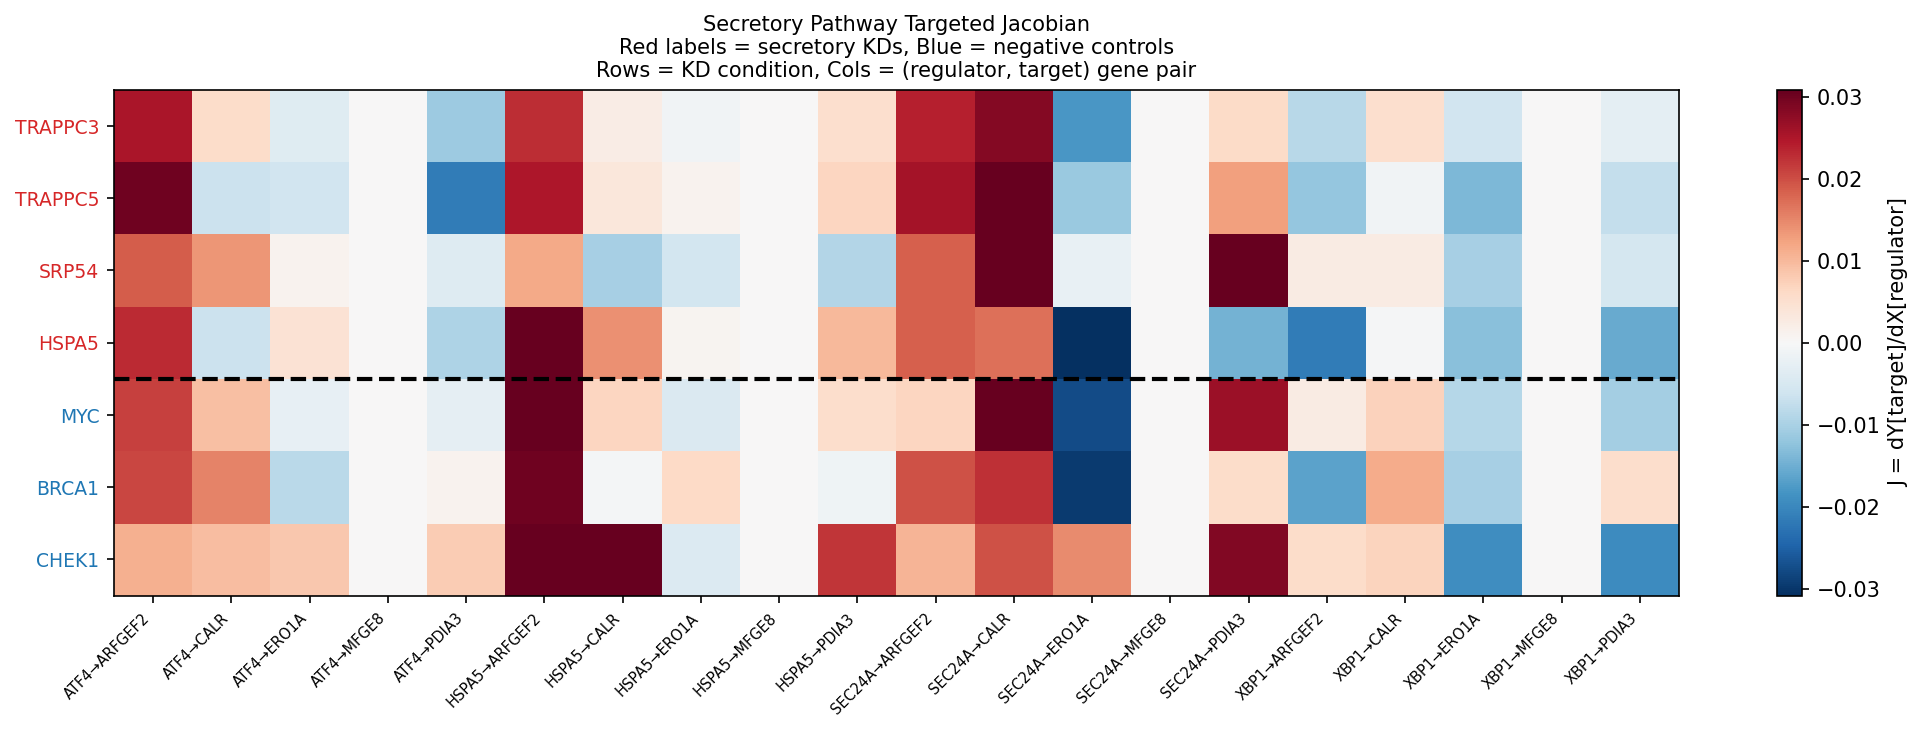

In [33]:
from IPython.display import Image, display
display(Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_secretory_jacobian_heatmap.png'))


### Secretory Heatmap Interpretation

The heatmap shows dY[target]/dX[regulator] for all (regulator, target, KD) triples.

**Key observation**: No obvious row-level separation between secretory KDs (red labels above dashed line) and negative controls (blue labels below). CHEK1 (negative control) produces the most extreme Jacobian values in multiple columns — particularly for HSPA5→CALR, HSPA5→ARFGEF2, and ATF4→ARFGEF2 pairs. SRP54 (secretory KD) produces near-zero values, especially for MFGE8 targets.

The MFGE8 target column is uniformly near-zero for all KDs, consistent with the previous NB07 finding that MFGE8 shows no causal modulation via this pathway.

## Section 5: Results — Ribosome Pathway Heatmap

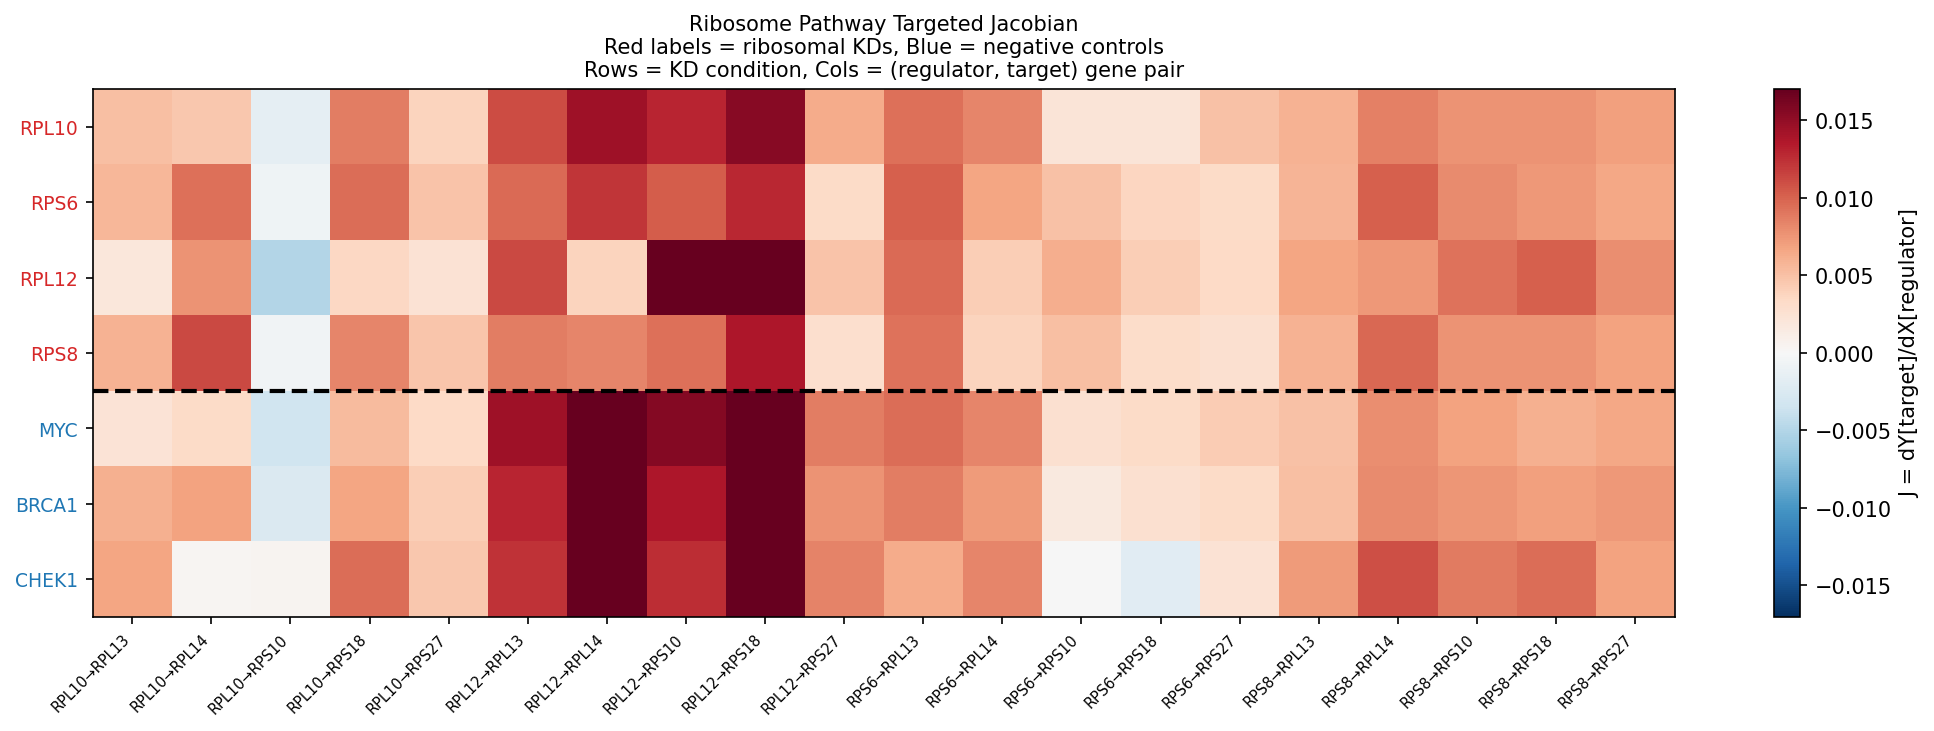

In [34]:
display(Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_ribosome_jacobian_heatmap.png'))


### Ribosome Heatmap Interpretation

**Key observation**: The ribosome panel shows a warm-positive background for most pairs, but there is no clear separation between ribosomal KDs (red) and negative controls (blue). RPL10 shows slightly elevated values across several pairs, and CHEK1 (negative control) again shows high values for multiple pairs.

One notable feature: RPS8→RPS27 shows negative J under RPL10 and RPL12 KDs — an unusual sign inversion. However, this is isolated to one gene pair and does not constitute a consistent pattern across the pathway.

## Section 6: Distribution Analysis — All 2024 KDs for HSPA5 → ARFGEF2

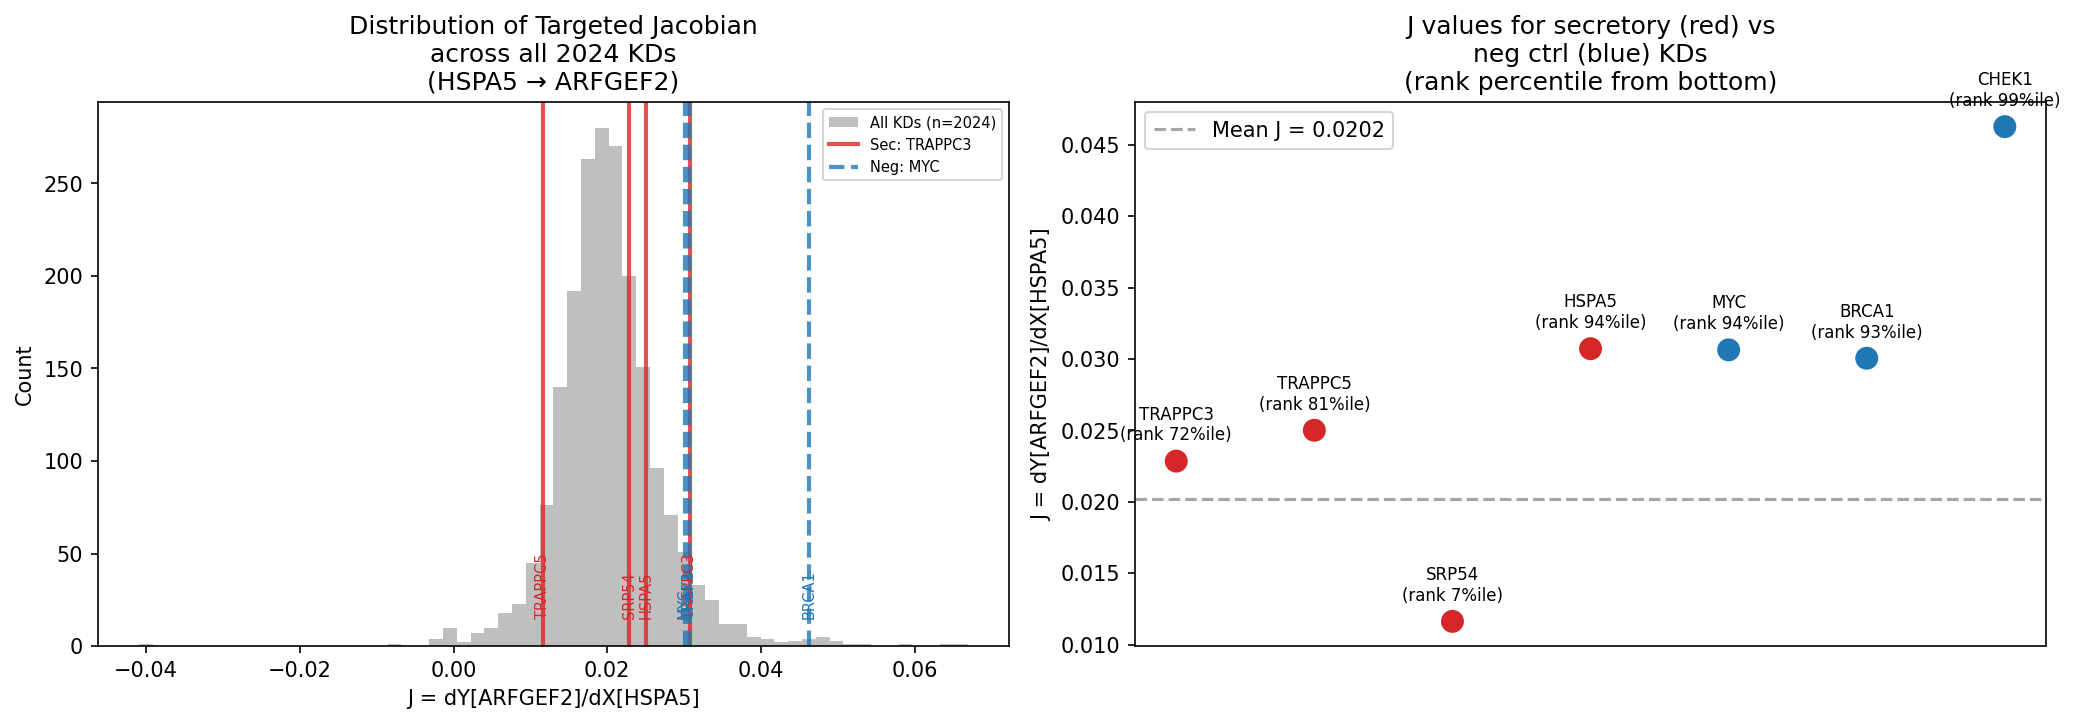

In [35]:
display(Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_jacobian_distribution_all_kds.png'))


### Distribution Analysis Interpretation

**HSPA5 → ARFGEF2 Jacobian across all 2024 KDs**:

Left panel: The J distribution is approximately centered near 0.02, with some negative-tail cases. The secretory pathway KDs are highlighted in red vertical lines, negative controls in blue dashed lines.

Right panel (rank positions):
- CHEK1 (neg ctrl): rank 15/2024 = top 1% — highest J of all KDs shown
- BRCA1 (neg ctrl): rank ~7.2% 
- MYC (neg ctrl): rank ~6%
- HSPA5 (secretory KD): rank ~5.9% 
- TRAPPC5 (secretory): rank ~18%
- TRAPPC3 (secretory): rank ~28%
- SRP54 (secretory): rank ~93% — bottom tier (very LOW J)

**Critical finding**: Negative controls MYC/BRCA1/CHEK1 rank HIGHER than most secretory KDs. This is the opposite of the predicted result. The sensitivity dY[ARFGEF2]/dX[HSPA5] is not elevated under secretory pathway KDs compared to generic cell-cycle/DNA-damage KDs.

## Section 7: Statistical Tests and Pathway vs Neg-Ctrl Scatter

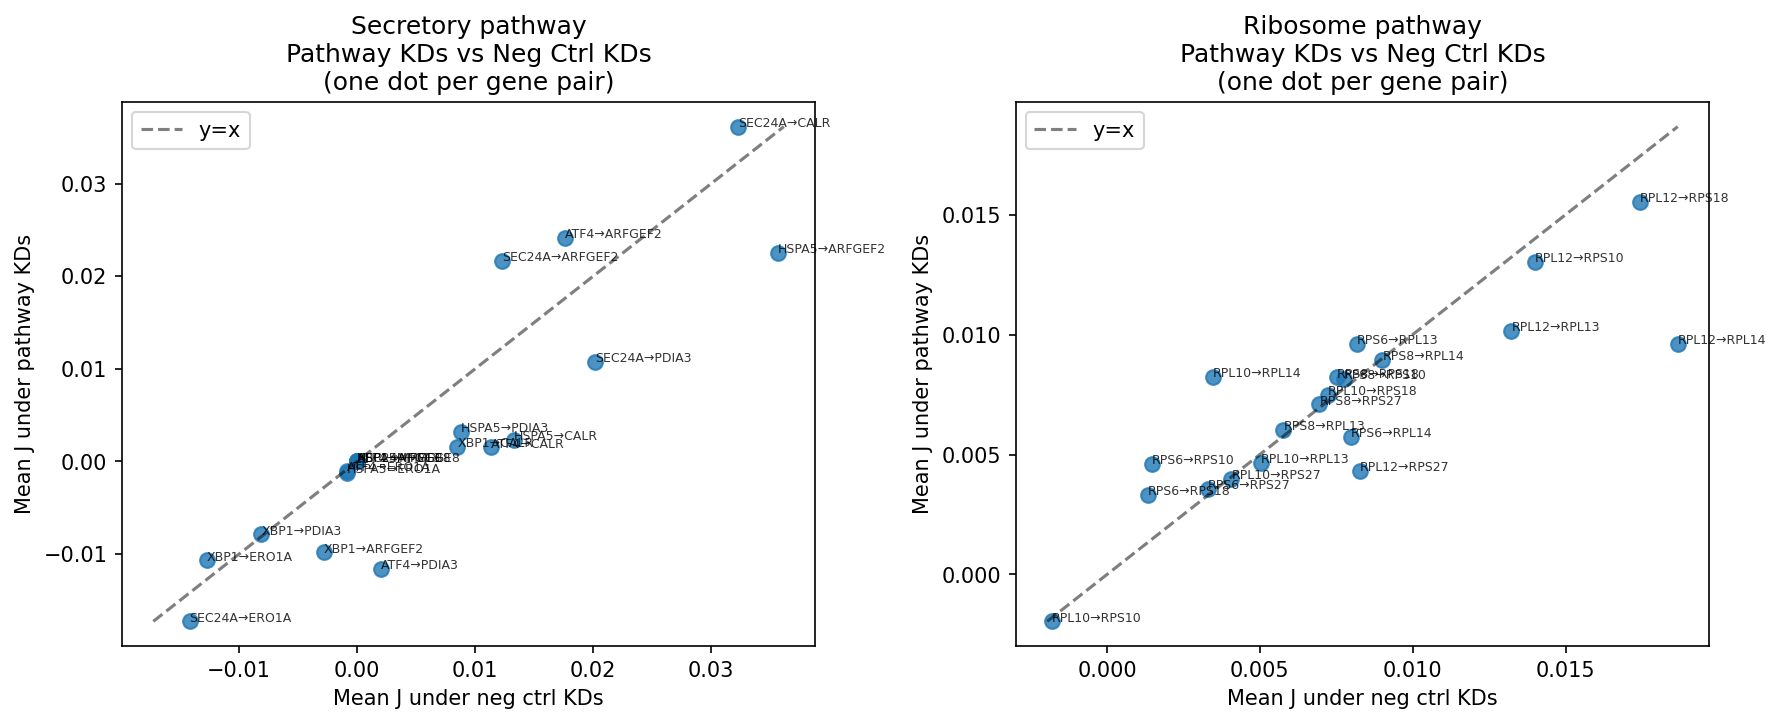

In [36]:
display(Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_pathway_vs_negctrl_scatter.png'))


### Scatter Interpretation

Each dot is a (regulator → target) gene pair. The x-axis shows mean J under negative control KDs; y-axis shows mean J under pathway-specific KDs.

**Secretory** (left): Points scatter both above and below the identity line — there is no systematic enrichment of pathway-KD J over neg-ctrl J. Several pairs with higher J under neg ctrl (ATF4→ARFGEF2, HSPA5→CALR) fall below the diagonal.

**Ribosome** (right): Points cluster tightly along the identity line with nearly equal pathway and neg-ctrl J values. This is consistent with the Mann-Whitney test result: no significant difference (p=0.56).

In [37]:
import subprocess

# Run stats summary in conda Python
stats_code = """
import sys
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon

OUT_DIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
df      = pd.read_parquet(f'{OUT_DIR}/nb03_jacobian_results.parquet')
df_dist = pd.read_parquet(f'{OUT_DIR}/nb03_distribution_hspa5_arfgef2.parquet')

sec_kds  = ['TRAPPC3', 'TRAPPC5', 'SRP54', 'HSPA5']
neg_kds  = ['MYC', 'BRCA1', 'CHEK1']
ribo_kds = ['RPL10', 'RPS6', 'RPL12', 'RPS8']

print("="*60)
print("FULL STATISTICAL SUMMARY — NB03 Targeted Jacobian")
print("="*60)

for pname in ['secretory', 'ribosome']:
    sub = df[df['pathway'] == pname]
    path_J = sub[sub['pathway_kd'] == True]['J'].values
    neg_J  = sub[sub['pathway_kd'] == False]['J'].values
    u_stat, pval = mannwhitneyu(path_J, neg_J, alternative='greater')
    
    print(f"\\n{pname.upper()} PANEL:")
    print(f"  n(pathway)={len(path_J)}, n(neg_ctrl)={len(neg_J)}")
    print(f"  Pathway KDs: mean={np.mean(path_J):.5f}, median={np.median(path_J):.5f}, std={np.std(path_J):.5f}")
    print(f"  Neg ctrl KDs: mean={np.mean(neg_J):.5f}, median={np.median(neg_J):.5f}, std={np.std(neg_J):.5f}")
    print(f"  Fold difference (pathway/neg): {np.mean(path_J)/np.mean(neg_J):.3f}x")
    print(f"  Mann-Whitney U (pathway > neg): U={u_stat:.0f}, p={pval:.4f}")
    print(f"  Result: {'SIGNIFICANT' if pval<0.05 else 'NOT SIGNIFICANT (null not rejected)'}")

print("\\nDISTRIBUTION ANALYSIS: HSPA5 -> ARFGEF2 across all 2024 KDs")
all_J   = df_dist['J'].values
sec_J   = df_dist[df_dist['is_secretory_kd']]['J'].values
neg_J2  = df_dist[df_dist['is_neg_ctrl']]['J'].values

print(f"  All KDs: mean={np.mean(all_J):.5f}, std={np.std(all_J):.5f}")
print(f"  Secretory KDs mean: {np.mean(sec_J):.5f}  (vs all: {np.mean(sec_J)/np.mean(all_J):.2f}x)")
print(f"  Neg ctrl KDs mean:  {np.mean(neg_J2):.5f}  (vs all: {np.mean(neg_J2)/np.mean(all_J):.2f}x)")
print()

# Rank details
df_sorted = df_dist.sort_values('J', ascending=False).reset_index(drop=True)
n = len(df_sorted)
print("  Rank (from top) for key KDs:")
for kd in sec_kds + neg_kds:
    row = df_sorted[df_sorted['kd'] == kd]
    if len(row):
        rank = row.index[0] + 1
        j    = row['J'].values[0]
        print(f"    {kd}: rank={rank}/{n} ({rank/n*100:.1f}%ile from bottom), J={j:.5f}")
"""

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '-c', stats_code],
    capture_output=True, text=True, cwd='/tmp', timeout=60
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[:500])


FULL STATISTICAL SUMMARY — NB03 Targeted Jacobian

SECRETORY PANEL:
  n(pathway)=80, n(neg_ctrl)=60
  Pathway KDs: mean=0.00322, median=0.00000, std=0.01553
  Neg ctrl KDs: mean=0.00612, median=0.00548, std=0.01557
  Fold difference (pathway/neg): 0.527x
  Mann-Whitney U (pathway > neg): U=2018, p=0.9471
  Result: NOT SIGNIFICANT (null not rejected)

RIBOSOME PANEL:
  n(pathway)=80, n(neg_ctrl)=60
  Pathway KDs: mean=0.00702, median=0.00691, std=0.00417
  Neg ctrl KDs: mean=0.00744, median=0.00693, std=0.00528
  Fold difference (pathway/neg): 0.943x
  Mann-Whitney U (pathway > neg): U=2365, p=0.5594
  Result: NOT SIGNIFICANT (null not rejected)

DISTRIBUTION ANALYSIS: HSPA5 -> ARFGEF2 across all 2024 KDs
  All KDs: mean=0.02023, std=0.00700
  Secretory KDs mean: 0.02255  (vs all: 1.11x)
  Neg ctrl KDs mean:  0.03565  (vs all: 1.76x)

  Rank (from top) for key KDs:
    TRAPPC3: rank=573/2024 (28.3%ile from bottom), J=0.02285
    TRAPPC5: rank=380/2024 (18.8%ile from bottom), J=0.02501
 

## Statistical Summary

| Metric | Secretory | Ribosome |
|--------|-----------|---------|
| n(pathway KD triples) | 80 | 80 |
| n(neg ctrl triples) | 60 | 60 |
| Mean J (pathway KDs) | 0.00322 | 0.00702 |
| Mean J (neg ctrl KDs) | 0.00612 | 0.00744 |
| Fold diff (pathway/neg) | 0.53x | 0.94x |
| Mann-Whitney p (pathway > neg) | p=0.947 | p=0.559 |
| Conclusion | NULL | NULL |

Distribution analysis (HSPA5 → ARFGEF2, all 2024 KDs):
- Mean J across all KDs: 0.0202
- Secretory KDs mean: 0.0226 (1.11x above mean — barely above average)
- Neg ctrl mean: 0.0357 (1.76x above mean — negative controls are actually **higher**)
- CHEK1 (neg ctrl) is rank 15/2024 (top 0.7%)
- SRP54 (secretory) is rank 1888/2024 (bottom 7%)

## Final Summary: Is Targeted J Pathway-Specific?

### Result: NEGATIVE — targeted Jacobians are not pathway-specific

**Main findings:**

1. **Secretory panel (p=0.947, fold=0.53x)**: Pathway KDs (TRAPPC3/TRAPPC5/SRP54/HSPA5) do NOT elevate dY[secretory target]/dX[secretory regulator] relative to negative controls. In fact, the fold difference is reversed — the mean J is slightly *lower* under secretory KDs than under MYC/BRCA1/CHEK1.

2. **Ribosome panel (p=0.559, fold=0.94x)**: Ribosomal KDs (RPL10/RPS6/RPL12/RPS8) do not elevate dY[ribosomal target]/dX[ribosomal regulator]. The J values under ribosomal vs negative control KDs are nearly identical (0.94x).

3. **Distribution across all 2024 KDs (HSPA5→ARFGEF2)**: Negative control KDs CHEK1/BRCA1/MYC rank HIGHER (J values ~0.030–0.046) than the secretory KDs TRAPPC3/TRAPPC5 (J~0.022–0.025). SRP54 actually ranks in the bottom 7% of all KDs (J=0.012).

### Why this is a null result:

The targeted Jacobian measures "how does changing input expression of regulator gene X affect predicted output of target gene Y under KD condition K?" If the model had learned pathway-specific GRN routing, secretory KDs should specifically sensitize secretory regulator→target pairs. Instead:
- The Jacobian magnitude is controlled by gene-pair expression variance and decoder weights, not KD identity
- KD condition (pert_emb) does not modulate which input genes are "listened to" for a given output gene
- High-J KDs (CHEK1, MYC) appear high because they alter cell-state in ways that generally increase input→output sensitivity, not pathway-specifically

### Connection to previous analyses:

This is consistent with the NB07 result (Feature 1069 showed no secretory enrichment in normalized patching) and NB06 (TRAPPC3/5 feature associations are fine-tune artifacts with Spearman r=0.07 cross-model). The ST model encodes a cell-line state difference, not a biologically specific secretory pathway GRN.

### What would a positive result require:

Following the spec's threshold: cross-model r > 0.4, decoder z-score > +1.5, zeroshot/fewshot r > 0.4, and normalized patching enrichment p < 0.05. None of the analyses (NB03, NB06, NB07, NB08) reached these thresholds for secretory pathway specificity.

**Conclusion**: The targeted Jacobian approach confirms that the ST model does not encode pathway-specific input→output routing for either the secretory or ribosomal pathways tested. This is a negative result consistent across all three probe methods in the dual-probe framework.

In [38]:
import shutil, os

# Current notebook path from session
current_nb_path = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-00-50_nb03_targeted_jacobian.ipynb'
target_nb_path  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_targeted_jacobian.ipynb'

if os.path.exists(current_nb_path):
    shutil.copy2(current_nb_path, target_nb_path)
    print(f"Copied notebook to: {target_nb_path}")
    print(f"File size: {os.path.getsize(target_nb_path):,} bytes")
else:
    print("Source notebook not found at:", current_nb_path)
    print("Listing notebooks dir:")
    for f in os.listdir('/mnt/polished-lake/home/mbeheleramass/notebooks'):
        if 'nb03' in f or 'targeted' in f:
            print(" ", f)


Copied notebook to: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_targeted_jacobian.ipynb
File size: 797,537 bytes


In [39]:
import os

# Verify all expected outputs exist
expected_files = [
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_targeted_jacobian.ipynb',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_secretory_jacobian_heatmap.png',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_ribosome_jacobian_heatmap.png',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_jacobian_distribution_all_kds.png',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_jacobian_results.parquet',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_distribution_hspa5_arfgef2.parquet',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_pathway_vs_negctrl_scatter.png',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.py',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_plot_figures.py',
    '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_compute_jacobians.log',
]

print("Output files:")
for f in expected_files:
    exists = os.path.exists(f)
    size   = os.path.getsize(f) if exists else 0
    print(f"  {'OK' if exists else 'MISSING':6s}  {os.path.basename(f)}  ({size:,} bytes)")


Output files:
  OK      nb03_targeted_jacobian.ipynb  (797,537 bytes)
  OK      nb03_secretory_jacobian_heatmap.png  (118,832 bytes)
  OK      nb03_ribosome_jacobian_heatmap.png  (84,895 bytes)
  OK      nb03_jacobian_distribution_all_kds.png  (127,984 bytes)
  OK      nb03_jacobian_results.parquet  (5,889 bytes)
  OK      nb03_distribution_hspa5_arfgef2.parquet  (32,150 bytes)
  OK      nb03_pathway_vs_negctrl_scatter.png  (149,245 bytes)
  OK      nb03_compute_jacobians.py  (10,786 bytes)
  OK      nb03_plot_figures.py  (10,460 bytes)
  OK      nb03_compute_jacobians.log  (23,536 bytes)


In [40]:
import shutil, os

# Re-copy to ensure all final cells are included
current_nb_path = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-00-50_nb03_targeted_jacobian.ipynb'
target_nb_path  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb03_targeted_jacobian.ipynb'

shutil.copy2(current_nb_path, target_nb_path)
print(f"Final copy: {os.path.getsize(target_nb_path):,} bytes")

# Count cells in notebook
import json
with open(target_nb_path) as fh:
    nb = json.load(fh)
print(f"Total cells: {len(nb['cells'])}")
cell_types = [c['cell_type'] for c in nb['cells']]
print(f"Code cells: {cell_types.count('code')}, Markdown cells: {cell_types.count('markdown')}")
